In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy
import os
import pickle5 as pickle
import torchvision.models as models
%matplotlib inline
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def load_data(file_name):
    assert(os.path.exists(file_name+'.pkl'))
    with open(file_name + '.pkl', 'rb') as f:
        data = pickle.load(f)
    return data

In [5]:
def save_data(data, file_path):
    with open(file_path + '.pkl','wb') as f:
        pickle.dump(data,f,pickle.HIGHEST_PROTOCOL)

#### The Galaxy-zoo data can be found [here](https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge).  Data is prepared in "prepare_data.py" and saved in "galaxy_data.pkl". Refer to section 6 of the paper for a detailed description of preprocessing and human predictions modeling. In this notebook we only load the data which we previously generated using the "prepare_data.py".

In [6]:
constraints = [0.0,0.2,0.4,0.6,0.8,1.0]
data_path = 'galaxy_modified'
model_dir = 'models/'
res_dir = 'results/'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
if not os.path.exists(res_dir):
    os.mkdir(res_dir)

#### The CNN architecture that we used for image classification is a variant of [Deep Residual Networks](https://arxiv.org/abs/1512.03385).

# Our Method :

#### According to the optimal triage policy, the machine only is trained on the points on which the difference between the machine loss and human loss is less than $t_{P,b,m}$ (refer to equation 3 in the paper). This is equivalent to sorting the samples based on the difference of machine loss and human loss and then giving to machine the first $\max(\lceil (1-b) \, |D| \rceil, p)$ samples where $p$ is the number of samples with $\ell(m_{\theta_{t-1}}(x_{[i]}), y_{[i]}) - \ell(h_{[i]}, y_{[i]}) < 0$.

In [7]:
def find_machine_samples(machine_loss, hloss, constraint):
    
    diff = machine_loss - hloss
    argsorted_diff = torch.clone(torch.argsort(diff))
    num_outsource = int(constraint * machine_loss.shape[0])
    index = -num_outsource

    while (index < -1 and diff[argsorted_diff[index]] <= 0):
        index += 1
    
    if index==0:
        index = -1
    if index == -diff.shape[0]:
        index = 1
    machine_list = argsorted_diff[:index]

    return machine_list

#### Here we train the machine model on its points. In each iteration first, the machine points are found and then the machine model is trained on them. We use early stopping with a patience of 10 epochs based on the performance on the validation set to determine when to stop training.

In [6]:
def train_triage(data_path,constraint):
    machine_type = 'Differentiable'
    print('training machine model using constraint:',constraint,' and machine model: ',machine_type)
    data = load_data(data_path)
    X = torch.from_numpy(data['X']).float()
    Y = torch.from_numpy(data['Y']).long()
    hloss = data['hloss']
    
    val_X = torch.from_numpy(data['val']['X']).float()
    val_Y = torch.from_numpy(data['val']['Y']).long()
    val_hloss = data['val']['hloss']
    
    batch_size = 128
    num_batches = int(X.shape[0] / batch_size)
    val_num_batches = int(val_X.shape[0] / batch_size)
    
    num_epochs = 50
        
    mnet = models.resnet50()
    mnet.fc = torch.nn.Sequential(
        nn.Linear(2048, 2),
        nn.LogSoftmax(dim = -1)
    )
    mnet.to(device)
    optimizer = torch.optim.Adam(mnet.parameters())
    loss_func = torch.nn.NLLLoss(reduction='none')
    train_losses = []
    val_losses = []
    labels = []
    best_val_loss = 1000
    eps = 1e-4
    max_patience = 10
    patience = 0
    res = {}
    res['machine_loss'] = {}
    
    
    for epoch in range(num_epochs):
        print('----- epoch:',epoch, '-----')
        train_loss = 0
        with torch.no_grad():
            mprim = copy.deepcopy(mnet)
        machine_loss = []
        for i in range(num_batches):
            X_batch = X[i * batch_size: (i + 1) * batch_size].to(device)
            Y_batch = Y[i * batch_size: (i + 1) * batch_size].to(device)
            hloss_batch = hloss[i * batch_size: (i + 1) * batch_size].to(device)
            with torch.no_grad():
                machine_scores_batch = mprim(X_batch)
                machine_loss_batch = loss_func(machine_scores_batch,Y_batch)
                machine_loss.extend(machine_loss_batch.detach())
                
            machine_indices = find_machine_samples(machine_loss_batch, hloss_batch, constraint)
            
            X_machine = X_batch[machine_indices]
            Y_machine = Y_batch[machine_indices]
            optimizer.zero_grad()
            loss = loss_func(mnet(X_machine),Y_machine)
            loss.sum().backward()
            optimizer.step()
            train_loss += float(loss.mean())

        train_losses.append(train_loss / num_batches)
        print('machine_loss:', train_loss/num_batches)
        
        with torch.no_grad():
            val_loss = 0
            for i in range(val_num_batches):
                val_X_batch = val_X[i * batch_size: (i + 1) * batch_size].to(device)
                val_Y_batch = val_Y[i * batch_size: (i + 1) * batch_size].to(device)
                val_hloss_batch = val_hloss[i * batch_size: (i + 1) * batch_size].to(device)
                val_mscores_batch = mprim(val_X_batch)
                val_mloss_batch = loss_func(val_mscores_batch, val_Y_batch)
                val_machine_indices = find_machine_samples(val_mloss_batch,val_hloss_batch,constraint)
                val_loss += float(loss_func(mnet(val_X_batch[val_machine_indices]),val_Y_batch[val_machine_indices]).mean())
                
                
            val_loss /= val_num_batches
            print('val_loss:',val_loss) 

            if val_loss + eps < best_val_loss:
#                 torch.save(mnet.state_dict(), model_dir + 'm_' + machine_type + str(constraint))
                best_val_loss = val_loss
                print('updated the model')
                patience = 0
            else:
                patience += 1
            val_losses.append(val_loss)

        if patience > max_patience:
            print('no progress for 10 epochs... stopping training')
            break

        print('\n')
        del mprim
            
        if epoch%5==0:
            fig, ax = plt.subplots()
            plt.title('b = ' + str(constraint) + ' epoch : ' + str(epoch),fontsize=22)
            plt.xlim(-12,1.3)
            plt.ylim([-25,7])
            plt.xticks([-12,-6,0],[r'$2^{-12}$',r'$2^{-6}$',r'$2^0$'])
            plt.yticks([-20,-10,0],[r'$2^{-20}$',r'$2^{-10}$',r'$2^{0}$'])
            plt.xlabel(r'Human Loss',fontsize=22)
            plt.ylabel(r'Machine Loss',fontsize=22)
            line = np.linspace(-12,1.3,100)
            plt.plot(line,line,'--')
            machine_loss = torch.tensor(machine_loss, device = 'cpu')
            mindices = find_machine_samples(machine_loss[:500],hloss[:500],constraint)
            indices = torch.ones(500)
            indices[mindices] = 0
            plt.scatter(np.log2(hloss[:500].cpu().data.numpy()),np.log2(np.array(machine_loss[:500])),alpha=0.3,c=indices)  
            plt.show()
    
    del mnet
    del data
    del X
    del Y
    del hloss
    del val_X
    del val_Y
    del val_hloss

    
    plt.plot(range(len(train_losses)),train_losses,marker='o',label='train')
    plt.plot(range(len(val_losses)),val_losses,marker='o',label='validation')
    plt.legend()
    plt.title(machine_type + ' b = ' + str(constraint),fontsize=22)
    plt.xlabel(r'Time Step t',fontsize=22)
    plt.ylabel(r'Machine Loss',fontsize=20)
    plt.show()


training machine model using constraint: 0.0  and machine model:  Differentiable
----- epoch: 0 -----
machine_loss: 0.6831119889798372
val_loss: 0.49085641105969746
updated the model




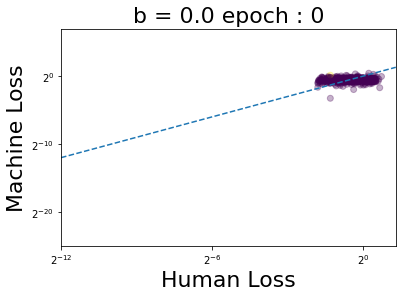

----- epoch: 1 -----
machine_loss: 0.5131567204776017
val_loss: 0.44279268980026243
updated the model


----- epoch: 2 -----
machine_loss: 0.49085048812886944
val_loss: 0.45546285112698875


----- epoch: 3 -----
machine_loss: 0.46632878482341766
val_loss: 0.42562591830889385
updated the model


----- epoch: 4 -----
machine_loss: 0.45546855421169946
val_loss: 0.4339532693227132


----- epoch: 5 -----
machine_loss: 0.4397729142852452
val_loss: 0.40550465186436974
updated the model




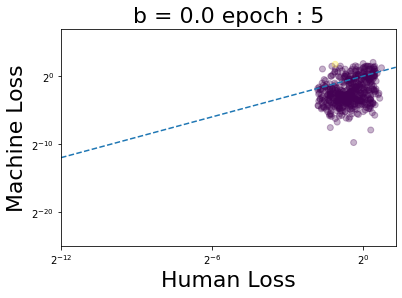

----- epoch: 6 -----
machine_loss: 0.43217992264291516
val_loss: 0.41330417394638064


----- epoch: 7 -----
machine_loss: 0.41551701530166296
val_loss: 0.4102664689222972


----- epoch: 8 -----
machine_loss: 0.4016123780089876
val_loss: 0.4084840695063273


----- epoch: 9 -----
machine_loss: 0.381525554086851
val_loss: 0.41021867990493777


----- epoch: 10 -----
machine_loss: 0.3748274225255717
val_loss: 0.3882250646750132
updated the model




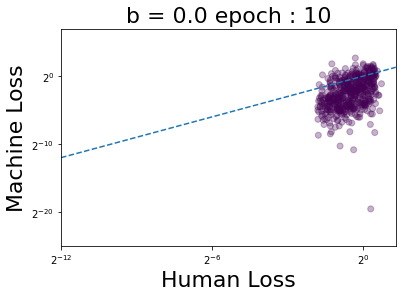

----- epoch: 11 -----
machine_loss: 0.3594349334421365
val_loss: 0.3853243370850881
updated the model


----- epoch: 12 -----
machine_loss: 0.35539053153732547
val_loss: 0.38693628907203675


----- epoch: 13 -----
machine_loss: 0.3387276549702105
val_loss: 0.3999147911866506


----- epoch: 14 -----
machine_loss: 0.3198574817051058
val_loss: 0.3967608948548635


----- epoch: 15 -----
machine_loss: 0.2967828395573989
val_loss: 0.4599056263764699




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: divide by zero encountered in log2


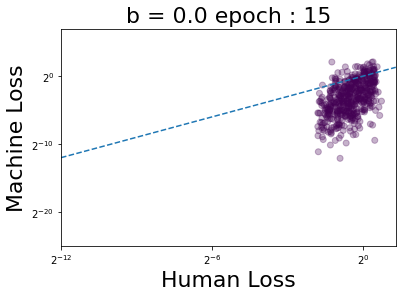

----- epoch: 16 -----
machine_loss: 0.32502272919468256
val_loss: 0.41300389568010965


----- epoch: 17 -----
machine_loss: 0.2732114451734916
val_loss: 0.5046945512294769


----- epoch: 18 -----
machine_loss: 0.2752244874187138
val_loss: 0.45691970785458885


----- epoch: 19 -----
machine_loss: 0.2755500026371168
val_loss: 0.406833291053772


----- epoch: 20 -----
machine_loss: 0.2429863191817118
val_loss: 0.46839059988657633




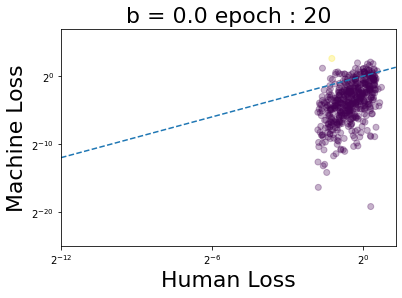

----- epoch: 21 -----
machine_loss: 0.20047325657113738
val_loss: 0.49158795873324074


----- epoch: 22 -----
machine_loss: 0.2083566723310429
val_loss: 0.5153786619504293
no progress for 10 epochs... stopping training


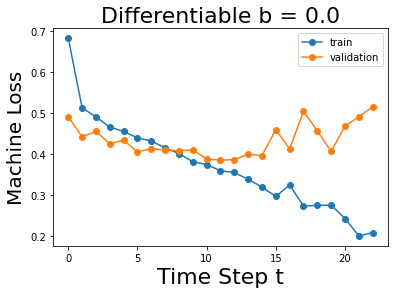

In [14]:
train_triage(data_path,0.0)

training machine model using constraint: 0.2  and machine model:  Differentiable
----- epoch: 0 -----
machine_loss: 0.6369125311789305
val_loss: 0.5115858753522237
updated the model




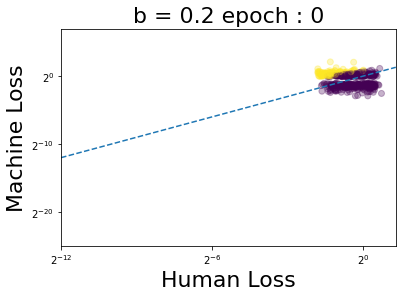

----- epoch: 1 -----
machine_loss: 0.26950644037645793
val_loss: 0.2449694146712621
updated the model


----- epoch: 2 -----
machine_loss: 0.1964122739660999
val_loss: 0.16756331821282705
updated the model


----- epoch: 3 -----
machine_loss: 0.1642093514294728
val_loss: 0.11714073767264684
updated the model


----- epoch: 4 -----
machine_loss: 0.13345789909362793
val_loss: 0.11035909429192543
updated the model


----- epoch: 5 -----
machine_loss: 0.12391442821725555
val_loss: 0.08740147054195405
updated the model




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: divide by zero encountered in log2


machine_loss: 0.09819221946046404
val_loss: 0.08122072219848633
updated the model


----- epoch: 9 -----
machine_loss: 0.09651481198227924
val_loss: 0.09116624469558397


----- epoch: 10 -----
machine_loss: 0.09055181104770821
val_loss: 0.07659091254075369
updated the model




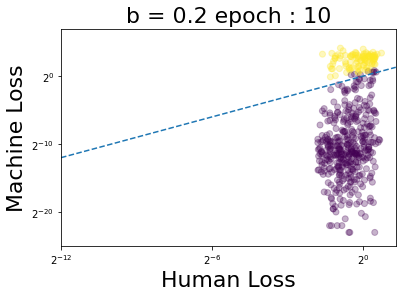

----- epoch: 11 -----
machine_loss: 0.0968972684248634
val_loss: 0.07992030953367552


----- epoch: 12 -----
machine_loss: 0.09939187530266202
val_loss: 0.0746365866313378
updated the model


----- epoch: 13 -----
machine_loss: 0.09892631451720776
val_loss: 0.05987472062309583
updated the model


----- epoch: 14 -----
machine_loss: 0.08550418557032295
val_loss: 0.06723932834963003


----- epoch: 15 -----
machine_loss: 0.07325686733035938
val_loss: 0.08092306479811669




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: divide by zero encountered in log2


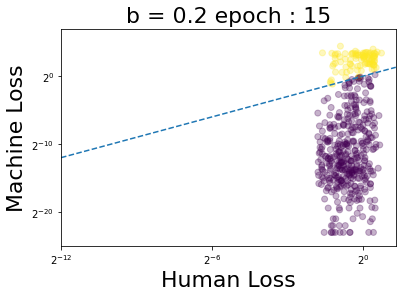

----- epoch: 16 -----
machine_loss: 0.07891491683119017
val_loss: 0.09744879603385925


----- epoch: 17 -----
machine_loss: 0.07523348113602918
val_loss: 0.06698954043289025


----- epoch: 18 -----
machine_loss: 0.06681845715755354
val_loss: 0.07763385884463787


----- epoch: 19 -----
machine_loss: 0.08064966984903035
val_loss: 0.10590701674421628


----- epoch: 20 -----
machine_loss: 0.08596859341892212
val_loss: 0.0723618995398283




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: divide by zero encountered in log2


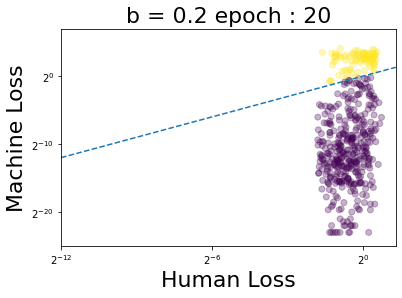

----- epoch: 21 -----
machine_loss: 0.07252492024765714
val_loss: 0.09443866933385531


----- epoch: 22 -----
machine_loss: 0.05825350413341885
val_loss: 0.08865610832969348


----- epoch: 23 -----
machine_loss: 0.08562518109607956
val_loss: 0.11606125409404437


----- epoch: 24 -----
machine_loss: 0.08113795605933537
val_loss: 0.11610916828115782
no progress for 10 epochs... stopping training


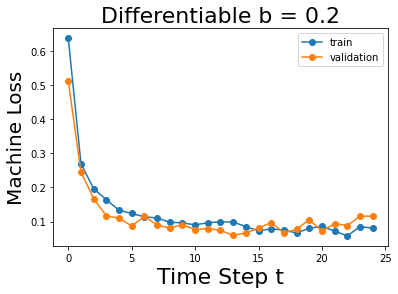

In [15]:
train_triage(data_path,0.2)

training machine model using constraint: 0.4  and machine model:  Differentiable
----- epoch: 0 -----
machine_loss: 0.42589131062445434
val_loss: 0.3577910969654719
updated the model




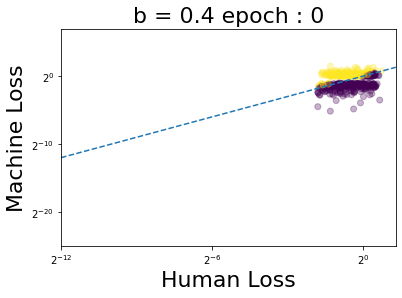

----- epoch: 1 -----
machine_loss: 0.17814536465574865
val_loss: 0.16089719583590825
updated the model


----- epoch: 2 -----
machine_loss: 0.14105861018533292
val_loss: 0.1422345628341039
updated the model


----- epoch: 3 -----
machine_loss: 0.11911421204390733
val_loss: 0.1565088133017222


----- epoch: 4 -----
machine_loss: 0.09116529843405537
val_loss: 0.09559954404830932
updated the model


----- epoch: 5 -----
machine_loss: 0.1006212375815148
val_loss: 0.11159099837144217




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: divide by zero encountered in log2


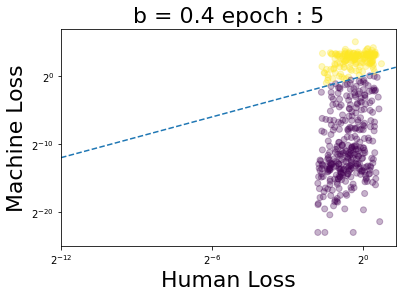

----- epoch: 6 -----
machine_loss: 0.11547845950269181
val_loss: 0.105221060415109


----- epoch: 7 -----
machine_loss: 0.08775054574336695
val_loss: 0.09311515937248865
updated the model


----- epoch: 8 -----
machine_loss: 0.08899862639120092
val_loss: 0.10545729200045267


----- epoch: 9 -----
machine_loss: 0.08030445877786564
val_loss: 0.11237838789820671


----- epoch: 10 -----
machine_loss: 0.07339694998834444
val_loss: 0.06425823383033276
updated the model




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: divide by zero encountered in log2


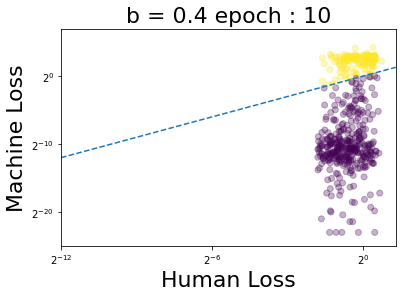

----- epoch: 11 -----
machine_loss: 0.0901721635752398
val_loss: 0.04971646157403787
updated the model


----- epoch: 12 -----
machine_loss: 0.07781687804052363
val_loss: 0.0649695744117101


----- epoch: 13 -----
machine_loss: 0.0644772329327205
val_loss: 0.08182010004917781


----- epoch: 14 -----
machine_loss: 0.08898589513062136
val_loss: 0.1006705383459727


----- epoch: 15 -----
machine_loss: 0.09272338032884442
val_loss: 0.05740277593334516




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: divide by zero encountered in log2


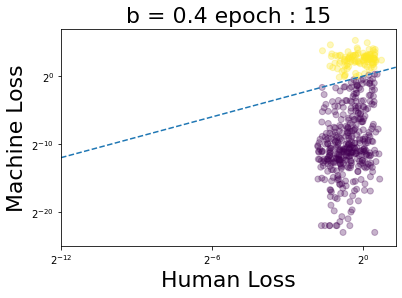

----- epoch: 16 -----
machine_loss: 0.08222594484686852
val_loss: 0.06920843782524268


----- epoch: 17 -----
machine_loss: 0.060997152923727815
val_loss: 0.056165653343002005


----- epoch: 18 -----
machine_loss: 0.055944719311335815
val_loss: 0.053459810589750606


----- epoch: 19 -----
machine_loss: 0.061753058350523526
val_loss: 0.06463738990326723


----- epoch: 20 -----
machine_loss: 0.04659248522037397
val_loss: 0.06995842928687732




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: divide by zero encountered in log2


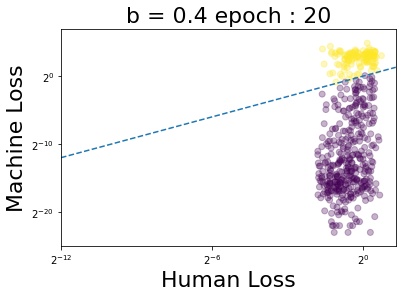

----- epoch: 21 -----
machine_loss: 0.08208830379273581
val_loss: 0.0831634578605493


----- epoch: 22 -----
machine_loss: 0.07591153077943169
val_loss: 0.058476770172516505
no progress for 10 epochs... stopping training


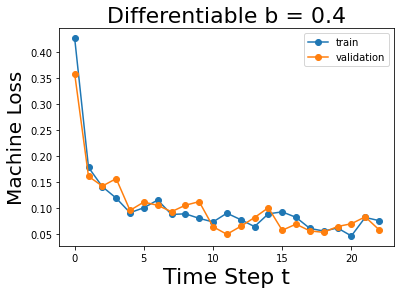

In [16]:
train_triage(data_path,0.4)

training machine model using constraint: 0.6  and machine model:  Differentiable
----- epoch: 0 -----
machine_loss: 0.3489705259385316
val_loss: 0.331433297197024
updated the model




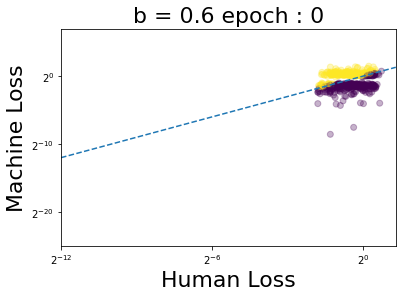

----- epoch: 1 -----
machine_loss: 0.02785431607900018
val_loss: 0.010870056847731272
updated the model


----- epoch: 2 -----
machine_loss: 0.005560782934955331
val_loss: 0.00796055378159508
updated the model


----- epoch: 3 -----
machine_loss: 0.0003035899626411265
val_loss: 7.29479130920178e-05
updated the model


----- epoch: 4 -----
machine_loss: 5.1343562241210904e-05
val_loss: 3.9388442625446864e-05


----- epoch: 5 -----
machine_loss: 3.160719133239068e-05
val_loss: 2.7086604071276572e-05




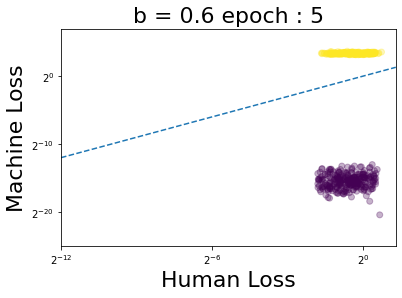

----- epoch: 6 -----
machine_loss: 2.2638160831063388e-05
val_loss: 2.025888764668101e-05


----- epoch: 7 -----
machine_loss: 1.7372010995092317e-05
val_loss: 1.59249895659741e-05


----- epoch: 8 -----
machine_loss: 1.3910703155093158e-05
val_loss: 1.2934457724137852e-05


----- epoch: 9 -----
machine_loss: 1.1461740264760168e-05
val_loss: 1.0763378607710668e-05


----- epoch: 10 -----
machine_loss: 9.644875055290987e-06
val_loss: 9.120531346222076e-06




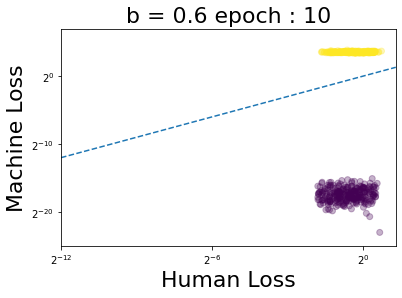

----- epoch: 11 -----
machine_loss: 8.24885891550208e-06
val_loss: 7.842217564757448e-06


----- epoch: 12 -----
machine_loss: 7.145981162861774e-06
val_loss: 6.820318291526443e-06


----- epoch: 13 -----
machine_loss: 6.255556063874594e-06
val_loss: 5.991118572031458e-06


----- epoch: 14 -----
machine_loss: 5.524692745023893e-06
val_loss: 5.305748588095109e-06
no progress for 10 epochs... stopping training


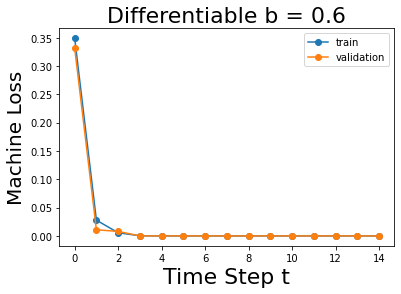

In [17]:
train_triage(data_path,0.6)

training machine model using constraint: 0.8  and machine model:  Differentiable
----- epoch: 0 -----
machine_loss: 0.6970796889584997
val_loss: 0.6017395158608755
updated the model




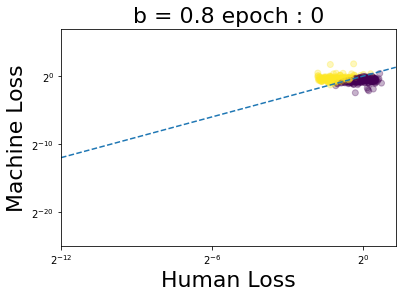

----- epoch: 1 -----
machine_loss: 0.3133443778623705
val_loss: 0.26763342022895814
updated the model


----- epoch: 2 -----
machine_loss: 0.10720327528922455
val_loss: 0.07710564931233724
updated the model


----- epoch: 3 -----
machine_loss: 0.10732248449779075
val_loss: 0.06600478142499924
updated the model


----- epoch: 4 -----
machine_loss: 0.08254054755620334
val_loss: 0.07869129478931428


----- epoch: 5 -----
machine_loss: 0.0858645448056252
val_loss: 0.07139157031973203




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: divide by zero encountered in log2


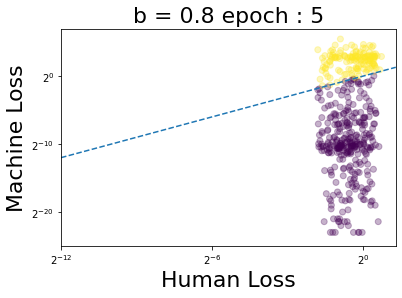

----- epoch: 6 -----
machine_loss: 0.055778982603679535
val_loss: 0.053593737880388896
updated the model


----- epoch: 7 -----
machine_loss: 0.07474926589866696
val_loss: 0.06521006760497888


----- epoch: 8 -----
machine_loss: 0.0636645340482178
val_loss: 0.04889145717024803
updated the model


----- epoch: 9 -----
machine_loss: 0.07045079666473296
val_loss: 0.05951310607294242


----- epoch: 10 -----
machine_loss: 0.06861127532370713
val_loss: 0.06211988168458144




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: divide by zero encountered in log2


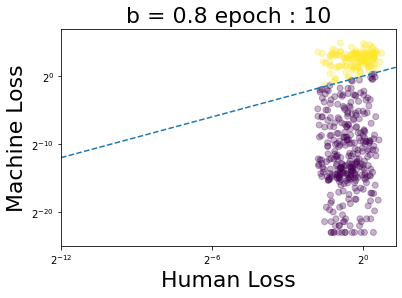

----- epoch: 11 -----
machine_loss: 0.07261858491793922
val_loss: 0.059951532259583475


----- epoch: 12 -----
machine_loss: 0.07149753709445181
val_loss: 0.048643350663284464
updated the model


----- epoch: 13 -----
machine_loss: 0.06558239763683599
val_loss: 0.07227147184312344


----- epoch: 14 -----
machine_loss: 0.060732295169778495
val_loss: 0.057033951642612615


----- epoch: 15 -----
machine_loss: 0.06969301999830034
val_loss: 0.07170676179230213




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: divide by zero encountered in log2


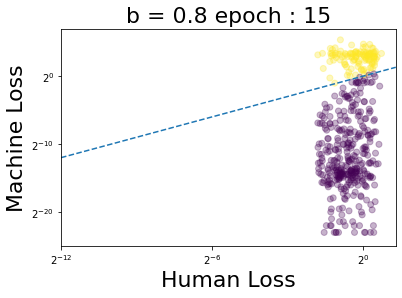

----- epoch: 16 -----
machine_loss: 0.07634998793187349
val_loss: 0.06013138362516959


----- epoch: 17 -----
machine_loss: 0.06589171091985443
val_loss: 0.04851630603273709
updated the model


----- epoch: 18 -----
machine_loss: 0.06751372827135999
val_loss: 0.05303969619174798


----- epoch: 19 -----
machine_loss: 0.0699758246217085
val_loss: 0.07366138212382793


----- epoch: 20 -----
machine_loss: 0.07738395403746677
val_loss: 0.09317800650993983




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: divide by zero encountered in log2


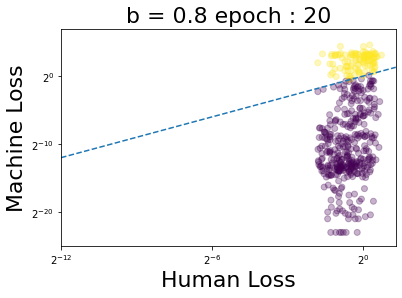

----- epoch: 21 -----
machine_loss: 0.06619729259577782
val_loss: 0.0905733206619819


----- epoch: 22 -----
machine_loss: 0.07123792475170415
val_loss: 0.0800355722506841


----- epoch: 23 -----
machine_loss: 0.06907852407058944
val_loss: 0.07179270188013713


----- epoch: 24 -----
machine_loss: 0.07352250458105751
val_loss: 0.08135360851883888


----- epoch: 25 -----
machine_loss: 0.0675194117686023
val_loss: 0.06179221831262112




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: divide by zero encountered in log2


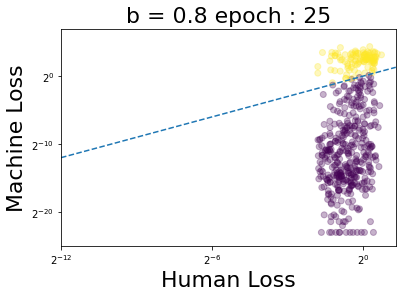

----- epoch: 26 -----
machine_loss: 0.06560218668259356
val_loss: 0.07263761162757873


----- epoch: 27 -----
machine_loss: 0.062004836762081024
val_loss: 0.06681453051666418


----- epoch: 28 -----
machine_loss: 0.06147256987574308
val_loss: 0.0709856195996205
no progress for 10 epochs... stopping training


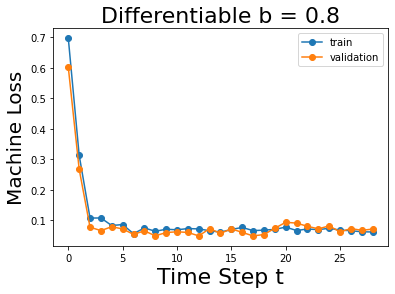

In [18]:
train_triage(data_path,0.8)

training machine model using constraint: 1.0  and machine model:  Differentiable
----- epoch: 0 -----
machine_loss: 0.15531674274445875
val_loss: 0.07914284703632196
updated the model




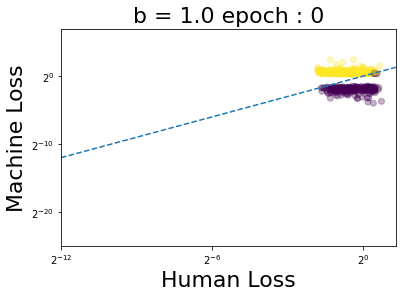

----- epoch: 1 -----
machine_loss: 0.0035621750051315917
val_loss: 3.3004872193487246e-06
updated the model


----- epoch: 2 -----
machine_loss: 2.9389296129090288e-06
val_loss: 2.5700562218844427e-06


----- epoch: 3 -----
machine_loss: 2.5549094845167057e-06
val_loss: 2.295600552315591e-06


----- epoch: 4 -----
machine_loss: 2.2777345026517413e-06
val_loss: 2.0448902735855275e-06


----- epoch: 5 -----
machine_loss: 2.0251103923447258e-06
val_loss: 1.8168957126363238e-06




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: divide by zero encountered in log2


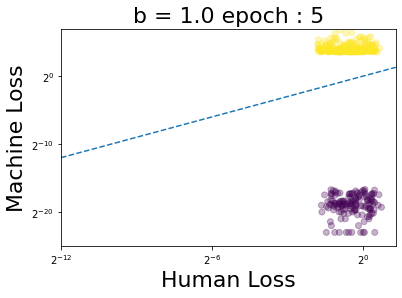

----- epoch: 6 -----
machine_loss: 1.7997410442722352e-06
val_loss: 1.6168619822565234e-06


----- epoch: 7 -----
machine_loss: 1.6012462155053389e-06
val_loss: 1.4433890100917779e-06


----- epoch: 8 -----
machine_loss: 1.4293933627067932e-06
val_loss: 1.2885757466089368e-06


----- epoch: 9 -----
machine_loss: 1.2795979683766705e-06
val_loss: 1.1563706796853997e-06


----- epoch: 10 -----
machine_loss: 1.1493412246280692e-06
val_loss: 1.040679668070273e-06




/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: divide by zero encountered in log2


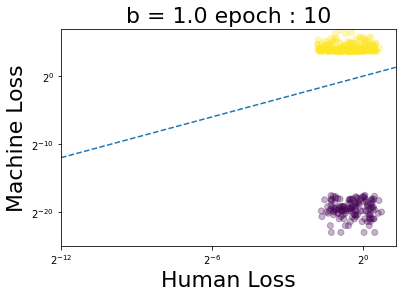

----- epoch: 11 -----
machine_loss: 1.0376115768721044e-06
val_loss: 9.402297015033886e-07


----- epoch: 12 -----
machine_loss: 9.377196433839028e-07
val_loss: 8.515198146596958e-07
no progress for 10 epochs... stopping training


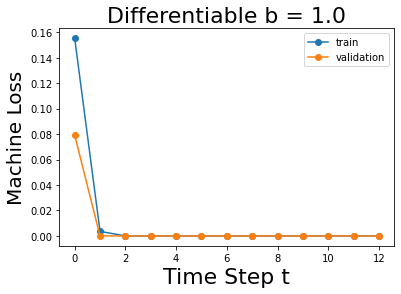

In [19]:
train_triage(data_path,1.0)

#### We train the additional model g to approximate difference of machine loss and human loss for unseen samples. The same CNN and the same training procedure is used for training g.

In [8]:
def train_g(data_path,constraint):
    machine_type = 'Differentiable'
    print('started training g using the constraint: ',constraint,' Using machine model: ',machine_type)
    data = load_data(data_path)
    train_X = torch.from_numpy(data['X']).float()
    train_Y = torch.from_numpy(data['Y']).long()
    train_hloss = data['hloss']
    
    with torch.no_grad():
        mnet = models.resnet50()
        mnet.fc = torch.nn.Sequential(
        nn.Linear(2048, 2),
        nn.LogSoftmax(dim = -1)
        )

        mnet.load_state_dict(torch.load(model_dir + 'm_Differentiable' + str(constraint)))
        mnet.to(device)
        mnet.eval()
    
    
    val_X = torch.from_numpy(data['test']['X']).float()
    val_Y = torch.from_numpy(data['test']['Y']).long()
    val_hloss = data['test']['hloss']
    
    batch_size = 128
    num_batches = int(train_X.shape[0] / batch_size)
    val_num_batches = int(val_X.shape[0] / batch_size)
    
    num_epochs = 40
    
    gnet = models.resnet50()
    gnet.fc = torch.nn.Sequential(
        nn.Linear(2048, 2),
        nn.LogSoftmax(dim = -1)
    )
    gnet.to(device)


    g_optimizer = torch.optim.Adam(gnet.parameters(),lr=0.001)
    loss_func = torch.nn.NLLLoss(reduction='none')
    

    train_losses = []
    val_losses = []
    best_val_loss = 1000
    max_patience = 8
    patience = 0
    eps = 1e-4
    res = {}
    res['g_train_loss'] = {}
    
    
    for epoch in range(num_epochs):
        machine_loss = []
        val_machine_loss = []
        gprediction = []
        val_gprediction = []
        glabels = []
        val_glabels = []
        rnd = np.random.permutation(train_X.shape[0])
        X, Y, hloss = train_X[rnd],train_Y[rnd],train_hloss[rnd]
        print('----- epoch:',epoch, '-----')
        g_train_loss = 0
        for i in range(num_batches):
            X_batch = X[i * batch_size: (i + 1) * batch_size].to(device)
            Y_batch = Y[i * batch_size: (i + 1) * batch_size].to(device)
            hloss_batch = hloss[i * batch_size: (i + 1) * batch_size].to(device)
            with torch.no_grad():
                machine_loss_batch = loss_func(mnet(X_batch),Y_batch)
                machine_indices = find_machine_samples(machine_loss_batch, hloss_batch, constraint)
            g_labels_batch = torch.tensor([0 if j in machine_indices else 1 for j in range(batch_size)]).to(device)
            g_optimizer.zero_grad()
            gpred = gnet(X_batch)
            g_loss = loss_func(gpred,g_labels_batch)
            g_loss.mean().backward()
            g_optimizer.step()
            g_train_loss += float(g_loss.mean())
            machine_loss.extend(machine_loss_batch)
            gprediction.extend(gpred[:,1])
            glabels.extend(g_labels_batch)
            
        train_losses.append(g_train_loss/num_batches)
        print('g_loss:',g_train_loss/num_batches) 
                  
        
        with torch.no_grad():
            val_gloss = 0
            for i in range(val_num_batches):
                val_X_batch = val_X[i * batch_size: (i + 1) * batch_size].to(device)
                val_Y_batch = val_Y[i * batch_size: (i + 1) * batch_size].to(device)
                val_hloss_batch = val_hloss[i * batch_size: (i + 1) * batch_size].to(device)
                val_mscores = mnet(val_X_batch)
                val_machine_loss_batch = loss_func(val_mscores,val_Y_batch)
                val_machine_loss.extend(val_machine_loss_batch)
                val_machine_indices = find_machine_samples(val_machine_loss_batch,val_hloss_batch,constraint)
                val_glabels_batch = torch.tensor([0 if j in val_machine_indices else 1 for j in range(val_X_batch.shape[0])]).to(device)
                val_glabels.extend(val_glabels_batch)
                val_gpred = gnet(val_X_batch)
                val_gprediction.extend(val_gpred[:,1])
                val_loss = loss_func(val_gpred,val_glabels_batch)
                val_gloss += float(val_loss.mean())
                
            val_gloss /= val_num_batches
            val_losses.append(val_gloss)
            print('val_g_loss:',float(val_gloss))

            if val_gloss + eps < best_val_loss:
#                 torch.save(gnet.state_dict(), model_dir + 'g_' + machine_type + str(constraint))
                best_val_loss = val_gloss
                print('updated the model')
                patience = 0
            else:
                patience += 1

        if patience > max_patience:
            print('no progress for 10 epochs... stopping training')
            break
                
        print('\n')
        
    del gnet
    del mnet
    
    
    
        
    plt.plot(range(len(train_losses)),train_losses,marker = 'o',label='train')
    plt.plot(range(len(val_losses)),val_losses,marker = 'o',label='validation')
    plt.title('train and validation curve of g using b = ' + str(constraint),fontsize=22)
    plt.xlabel('Epoch',fontsize=22)
    plt.ylabel(r'g Loss',fontsize=20)
    plt.legend()
    plt.show()
        

started training g using the constraint:  0.0  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.08132026749460594
val_g_loss: 0.05380109250545502
updated the model


----- epoch: 1 -----
g_loss: 0.05422085636983747
val_g_loss: 0.051167818655570345
updated the model


----- epoch: 2 -----
g_loss: 0.051865164757422776
val_g_loss: 0.047917540371418
updated the model


----- epoch: 3 -----
g_loss: 0.055118073547339955
val_g_loss: 0.04809251328309377


----- epoch: 4 -----
g_loss: 0.049115444655003754
val_g_loss: 0.04621499056617419
updated the model


----- epoch: 5 -----
g_loss: 0.04711335929839507
val_g_loss: 0.04746421724557877


----- epoch: 6 -----
g_loss: 0.04511694816629524
val_g_loss: 0.044759053240219754
updated the model


----- epoch: 7 -----
g_loss: 0.04397031729635985
val_g_loss: 0.04573972523212433


----- epoch: 8 -----
g_loss: 0.04322379677677932
val_g_loss: 0.04517727891604106


----- epoch: 9 -----
g_loss: 0.04264972865095605
val_g_loss: 0.0469231188297

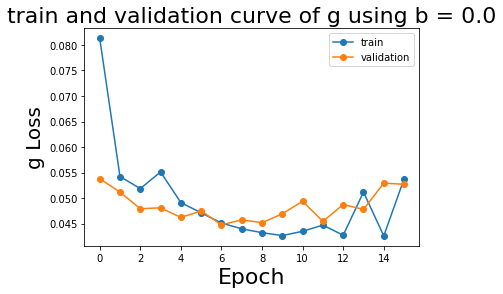

In [27]:
train_g(data_path,0.0)

started training g using the constraint:  0.2  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.4930180557396101
val_g_loss: 0.46450583934783934
updated the model


----- epoch: 1 -----
g_loss: 0.43572057913178985
val_g_loss: 0.475862991809845


----- epoch: 2 -----
g_loss: 0.4259371174418408
val_g_loss: 0.4701158285140991


----- epoch: 3 -----
g_loss: 0.42426642581172613
val_g_loss: 0.4587967574596405
updated the model


----- epoch: 4 -----
g_loss: 0.41965667125971423
val_g_loss: 0.4613219400246938


----- epoch: 5 -----
g_loss: 0.42108711017214734
val_g_loss: 0.44669903119405113
updated the model


----- epoch: 6 -----
g_loss: 0.41884632667769556
val_g_loss: 0.44868569175402323


----- epoch: 7 -----
g_loss: 0.4258951143078182
val_g_loss: 0.4599434435367584


----- epoch: 8 -----
g_loss: 0.4166418527779372
val_g_loss: 0.4584771911303202


----- epoch: 9 -----
g_loss: 0.4153179338444834
val_g_loss: 0.4499403794606527


----- epoch: 10 -----
g_loss: 0.4084708198257

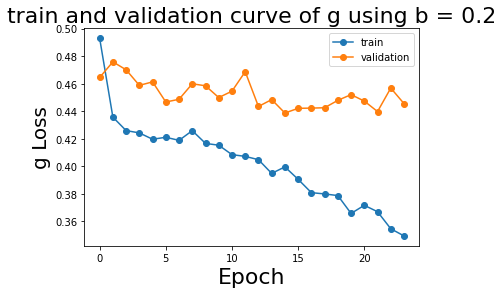

In [28]:
train_g(data_path,0.2)

started training g using the constraint:  0.4  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.5087609615014947
val_g_loss: 0.46731411616007484
updated the model


----- epoch: 1 -----
g_loss: 0.45224778937256854
val_g_loss: 0.47034045656522117


----- epoch: 2 -----
g_loss: 0.45126966872940893
val_g_loss: 0.4676041861375173


----- epoch: 3 -----
g_loss: 0.44582186963247217
val_g_loss: 0.4688256919384003


----- epoch: 4 -----
g_loss: 0.4504705181588297
val_g_loss: 0.4652879635492961
updated the model


----- epoch: 5 -----
g_loss: 0.4458350720612899
val_g_loss: 0.4924854298432668


----- epoch: 6 -----
g_loss: 0.44911603305650794
val_g_loss: 0.48077061971028645


----- epoch: 7 -----
g_loss: 0.4473919220592665
val_g_loss: 0.45258316000302634
updated the model


----- epoch: 8 -----
g_loss: 0.4461194017659063
val_g_loss: 0.46513551274935405


----- epoch: 9 -----
g_loss: 0.4414864623028299
val_g_loss: 0.4614925503730774


----- epoch: 10 -----
g_loss: 0.43392952045

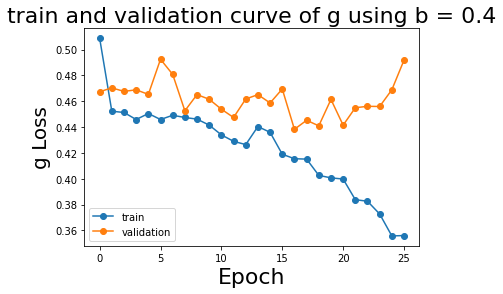

In [29]:
train_g(data_path,0.4)

started training g using the constraint:  0.6  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.5579940119515294
val_g_loss: 0.47392786542574566
updated the model


----- epoch: 1 -----
g_loss: 0.4713029738353646
val_g_loss: 0.4811372915903727


----- epoch: 2 -----
g_loss: 0.4656566323145576
val_g_loss: 0.46908928751945494
updated the model


----- epoch: 3 -----
g_loss: 0.46118796454823535
val_g_loss: 0.4632812956968943
updated the model


----- epoch: 4 -----
g_loss: 0.45860973324464716
val_g_loss: 0.45996387203534445
updated the model


----- epoch: 5 -----
g_loss: 0.4543981778880824
val_g_loss: 0.46124399503072105


----- epoch: 6 -----
g_loss: 0.45639375759207684
val_g_loss: 0.45326627294222516
updated the model


----- epoch: 7 -----
g_loss: 0.4468849864990815
val_g_loss: 0.46377663215001425


----- epoch: 8 -----
g_loss: 0.44339555987845297
val_g_loss: 0.4944515069325765


----- epoch: 9 -----
g_loss: 0.4387872562460277
val_g_loss: 0.4352882424990336
updated 

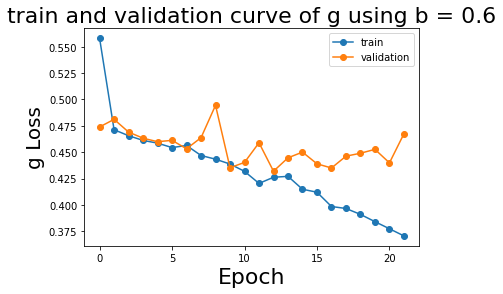

In [30]:
train_g(data_path,0.6)

started training g using the constraint:  0.8  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.6205496399298959
val_g_loss: 0.5426567653814952
updated the model


----- epoch: 1 -----
g_loss: 0.5300505135370337
val_g_loss: 0.5576354583104451


----- epoch: 2 -----
g_loss: 0.5229991816956064
val_g_loss: 0.5232426047325134
updated the model


----- epoch: 3 -----
g_loss: 0.5137204126171444
val_g_loss: 0.5503284752368927


----- epoch: 4 -----
g_loss: 0.5237581069054811
val_g_loss: 0.5371810714403789


----- epoch: 5 -----
g_loss: 0.5092543266389681
val_g_loss: 0.5083174526691436
updated the model


----- epoch: 6 -----
g_loss: 0.49439188838005066
val_g_loss: 0.5194737553596497


----- epoch: 7 -----
g_loss: 0.4918934968502625
val_g_loss: 0.5048430144786835
updated the model


----- epoch: 8 -----
g_loss: 0.4859469597754271
val_g_loss: 0.4993545671304067
updated the model


----- epoch: 9 -----
g_loss: 0.486476204317549
val_g_loss: 0.49541914264361064
updated the model

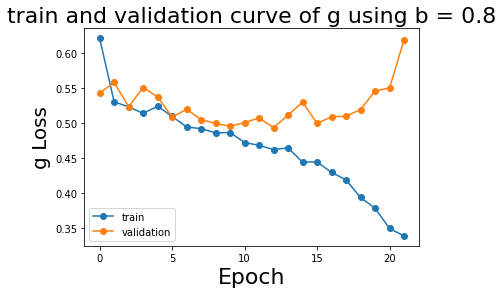

In [31]:
train_g(data_path,0.8)

started training g using the constraint:  1.0  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.6505630132944688
val_g_loss: 0.4730693797270457
updated the model


----- epoch: 1 -----
g_loss: 0.4922609037679175
val_g_loss: 0.4809827983379364


----- epoch: 2 -----
g_loss: 0.4539047252872716
val_g_loss: 0.507102620601654


----- epoch: 3 -----
g_loss: 0.4482898893563644
val_g_loss: 0.39775122205416363
updated the model


----- epoch: 4 -----
g_loss: 0.4229368962671446
val_g_loss: 0.43065345287323


----- epoch: 5 -----
g_loss: 0.4080658075602158
val_g_loss: 0.4051221172014872


----- epoch: 6 -----
g_loss: 0.3924962159084237
val_g_loss: 0.40115652879079183


----- epoch: 7 -----
g_loss: 0.4005113775315492
val_g_loss: 0.4130997280279795


----- epoch: 8 -----
g_loss: 0.3784673615642216
val_g_loss: 0.39223782618840536
updated the model


----- epoch: 9 -----
g_loss: 0.361991114590479
val_g_loss: 0.38146432240804035
updated the model


----- epoch: 10 -----
g_loss: 0.36

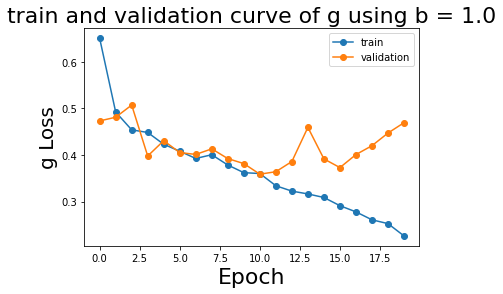

In [32]:
train_g(data_path,1.0)

In [33]:
def get_test_assignments_us(constraints):
    machine_type = 'Differentiable'
    res_path = res_dir + machine_type
    res = {}
    threshold_map = {0.0:0.0,0.2:0.257,0.4:0.257,0.6:0.211,0.8:0.211,1.0:0.373}
    
    with torch.no_grad():
        loss_func = torch.nn.NLLLoss(reduction='none')
        data = load_data(data_path)
        test_X = torch.from_numpy(data['test']['X']).float().to(device)
        test_Y = torch.from_numpy(data['test']['Y']).long().to(device)
        hlabel = torch.from_numpy(data['test']['hpred']).to(device)
        hcrossloss = (data['test']['hloss']).to(device)
        
        losses = []
        for constraint in constraints:
            res[constraint] = {}
            test_Y = test_Y.to(device)
            loss = np.zeros(test_X.shape[0])
            num_machine = int((1.0 - constraint) * test_X.shape[0])
            
            mnet = models.resnet50()
            mnet.fc = torch.nn.Sequential(
            nn.Linear(2048, 2),
            nn.LogSoftmax(dim = -1)
            )
            mnet.to(device)

            mnet.load_state_dict(torch.load(model_dir + 'm_Differentiable' + str(constraint)))
            mnet.eval()


            mscores = mnet(test_X)
            machine_conf, _ = torch.max(mscores,axis = 1)
            mcrossloss = loss_func(mscores,test_Y)
            mlabel = torch.argmax(mscores,dim=1)

            gnet = models.resnet50()
            gnet.fc = torch.nn.Sequential(
            nn.Linear(2048, 2),
            nn.LogSoftmax(dim = -1)
            )
            gnet.to(device)

            gnet.load_state_dict(torch.load(model_dir + 'g_Differentiable' + str(constraint)))
            gnet.eval()

            gprediction = torch.exp(gnet(test_X).detach()[:,1])
            human_candidates = torch.argsort(gprediction)[num_machine:]
            to_machine = [i for i in range(mlabel.shape[0]) if i not in human_candidates or gprediction[i]<threshold_map[constraint]]
            
            to_human = np.array([i for i in range(mlabel.shape[0]) if i not in to_machine])

            print('number of samples to machine: ',len(to_machine),'number of samples to human:', len(to_human))
            
            mloss = np.not_equal(mlabel.cpu(),test_Y.cpu())
            hloss = np.not_equal(hlabel.cpu(),test_Y.cpu())
            
            if len(to_machine)!=0:
                loss[to_machine] = mloss[to_machine]
                print('mean of machine error:' ,np.mean(loss[to_machine]))
            if to_human.shape[0]!=0:
                loss[to_human] = hloss[to_human]
                print('mean of human error:' ,np.mean(loss[to_human]))
            
            color = torch.zeros(mcrossloss.shape[0])
            color[to_machine] = 1
            res[constraint]['mcrossloss'] = mcrossloss
            res[constraint]['mpredloss'] = mloss
            res[constraint]['mlabel'] = mlabel
            res[constraint]['mconf'] = machine_conf
            res[constraint]['mscore'] = mscores
            res[constraint]['hcrossloss'] = hcrossloss
            res[constraint]['hpredloss'] = hloss
            res[constraint]['hlabel'] = hlabel
            res[constraint]['gprediction'] = gprediction
            res[constraint]['to_machine'] = to_machine
            res[constraint]['to_human'] = to_human
            res[constraint]['agg_loss'] = np.mean(loss)
            print('-----')

            losses.append(np.mean(loss))
            del mnet
            del gnet
            del mcrossloss
            del mlabel
            del machine_conf
            del mscores
            del gprediction
            del to_machine
            del to_human


        plt.plot(constraints,losses,marker='o')
        plt.xticks(constraints)
        plt.title(r'our method',fontsize=22)
        plt.ylabel(r'misclassification error',fontsize=22)
        plt.xlabel(r'b',fontsize=22)
        plt.show()
#         save_data(res,res_path)

number of samples to machine:  2000 number of samples to human: 0
mean of machine error: 0.196
-----
number of samples to machine:  1653 number of samples to human: 347
mean of machine error: 0.16394434361766486
mean of human error: 0.23919308357348704
-----
number of samples to machine:  1638 number of samples to human: 362
mean of machine error: 0.14590964590964592
mean of human error: 0.27624309392265195
-----
number of samples to machine:  1332 number of samples to human: 668
mean of machine error: 0.10135135135135136
mean of human error: 0.281437125748503
-----
number of samples to machine:  1104 number of samples to human: 896
mean of machine error: 0.10778985507246377
mean of human error: 0.2689732142857143
-----
number of samples to machine:  697 number of samples to human: 1303
mean of machine error: 0.11764705882352941
mean of human error: 0.2202609363008442
-----


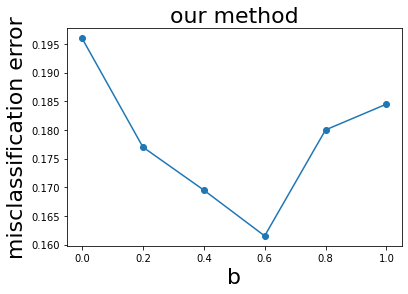

In [34]:
get_test_assignments_us(constraints)

In [35]:
def boxplot():
    constraints = [0.4, 0.6, 0.8, 1.0]
    res = load_data('results/Differentiable')
    for constraint in constraints:
        fig, ax = plt.subplots()

        gpred = res[constraint]['gprediction'].cpu()
        mloss = res[constraint]['mcrossloss'].cpu()
        hloss = res[constraint]['hcrossloss'].cpu()
        to_machine = res[constraint]['to_machine']
        to_human = res[constraint]['to_human']
        threshold_map = {0.0: 0.0, 0.2: 0.257, 0.4: 0.257, 0.6: 0.211, 0.8: 0.211, 1.0: 0.373}
        below = [idx for idx in range(gpred.shape[0]) if idx in to_machine]
        above = [idx for idx in range(gpred.shape[0]) if idx in to_human]
        below_data = [np.log2(mloss[idx]) - np.log2(hloss[idx]) for idx in below]
        above_data = [np.log2(mloss[idx]) - np.log2(hloss[idx]) for idx in above]
        
        medianprops = dict(linestyle='-.', linewidth=2.5, color='black')

        ax1 = ax.boxplot(np.array(below_data), positions=[0],  widths=0.35,sym='',whis=0,medianprops=medianprops,#usermedians=[np.mean(below_data)],
                         patch_artist=True, boxprops=dict(facecolor="C0"))
        ax2 = ax.boxplot(np.array(above_data), positions=[1],  widths=0.35,sym='',whis=0,medianprops = medianprops,#usermedians=[np.mean(above_data)],
                         patch_artist=True, boxprops=dict(facecolor="C1"))
        plt.show()


/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log2
  from ipykernel import kernelapp as app
/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log2
  app.launch_new_instance()


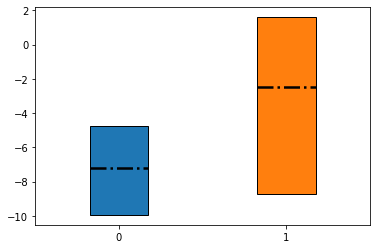

/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log2
  from ipykernel import kernelapp as app
/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log2
  app.launch_new_instance()


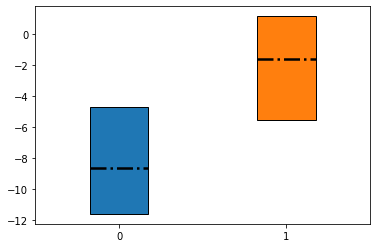

/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log2
  from ipykernel import kernelapp as app
/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log2
  app.launch_new_instance()


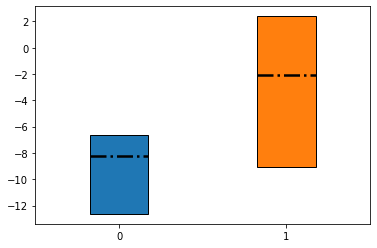

/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log2
  from ipykernel import kernelapp as app


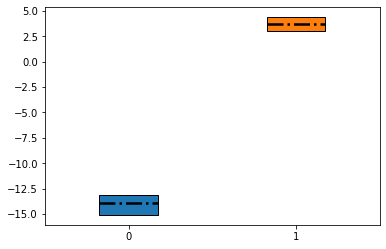

In [36]:
boxplot()

# Baselines

## [Confidence Based Triage](https://arxiv.org/abs/2004.13102)

In [20]:
def train_confidence(data_path,constraint):
    machine_type = 'confidence'
    print('-----training machine model using constraint:',constraint,' and machine model: ',machine_type)
    data = load_data(data_path)
    X = torch.from_numpy(data['X']).float()
    Y = torch.from_numpy(data['Y']).long()
    hconf = torch.mean(data['hconf']) + torch.zeros(X.shape[0])
    
    val_X = torch.from_numpy(data['val']['X']).float()
    val_Y = torch.from_numpy(data['val']['Y']).long()
    val_hconf = torch.mean(data['hconf']) + torch.zeros(val_X.shape[0])
    
    batch_size = 128
    num_batches = int(X.shape[0] / batch_size)
    val_num_batches = int(val_X.shape[0] / batch_size)
    
    num_epochs = 30
        
    mnet = models.resnet50()
    mnet.fc = torch.nn.Sequential(
        nn.Linear(mnet.fc.in_features, 2),
        nn.LogSoftmax(dim = -1)
    )
    mnet.to(device)
        
    optimizer = torch.optim.Adam(mnet.parameters(),lr=0.004)
    loss_func = torch.nn.NLLLoss(reduction='none')
    train_losses = []
    val_losses = []
    best_val_loss = 1000
    max_patience = 10
    patience = 0
    eps = 1e-4
    for epoch in range(num_epochs):
        print('----- epoch:',epoch, '-----')
        train_loss = 0
        with torch.no_grad():
            mprim = copy.deepcopy(mnet)
        machine_loss = []
        for i in range(num_batches):
            X_batch = X[i * batch_size: (i + 1) * batch_size].to(device)
            Y_batch = Y[i * batch_size: (i + 1) * batch_size].to(device)
            hconf_batch = hconf[i * batch_size: (i + 1) * batch_size].to(device)
            machine_scores_batch = mprim(X_batch)
            machine_conf_batch, _ = torch.max(machine_scores_batch,axis = 1)  
            machine_indices = find_machine_samples(hconf_batch,machine_conf_batch,constraint)
                
            X_machine = X_batch[machine_indices]
            Y_machine = Y_batch[machine_indices]
            optimizer.zero_grad()
            loss = loss_func(mnet(X_machine),Y_machine)
            loss.sum().backward()
            optimizer.step()
            train_loss += float(loss.mean())

        train_losses.append(train_loss / num_batches)
        print('machine_loss:', train_loss/num_batches)
        
        with torch.no_grad():
            val_loss = 0
            for i in range(val_num_batches):
                val_X_batch = val_X[i * batch_size: (i + 1) * batch_size].to(device)
                val_Y_batch = val_Y[i * batch_size: (i + 1) * batch_size].to(device)
                val_hconf_batch = val_hconf[i * batch_size: (i + 1) * batch_size].to(device)
                val_machine_scores = mprim(val_X_batch)
                val_machine_conf,_ = torch.max(val_machine_scores,axis=1)
                val_machine_indices = find_machine_samples(val_hconf_batch,val_machine_conf,constraint)
                val_loss += float(loss_func(mnet(val_X_batch[val_machine_indices]),val_Y_batch[val_machine_indices]).mean())

                
            val_loss /= val_num_batches
            print('val_loss:',val_loss) 

            if val_loss + eps < best_val_loss:
                torch.save(mnet.state_dict(), model_dir + 'm_' + machine_type + str(constraint))
                best_val_loss = val_loss
                print('updated the model')
                patience = 0
            else:
                patience += 1
            val_losses.append(val_loss)

                
        if patience > max_patience:
            print('no progress for 10 epochs... stopping training')
            break
      
        print('\n')
            
    plt.plot(range(len(train_losses)),train_losses,marker='o',label = 'train')
    plt.plot(range(len(val_losses)),val_losses,marker='o',label = 'validation')
    plt.legend()
    plt.title(machine_type + ' b = ' + str(constraint),fontsize=22)
    plt.xlabel(r'Time Step t',fontsize=22)
    plt.ylabel(r'Machine Loss',fontsize=20)
    plt.show()
        

-----training machine model using constraint: 0.0  and machine model:  confidence
----- epoch: 0 -----
machine_loss: 0.8248347069906152
val_loss: 0.5442720472812652
updated the model


----- epoch: 1 -----
machine_loss: 0.5668146027171094
val_loss: 0.5121766328811646
updated the model


----- epoch: 2 -----
machine_loss: 0.5282904913891917
val_loss: 0.5255578041076661


----- epoch: 3 -----
machine_loss: 0.5186186905788339
val_loss: 0.48511547247568765
updated the model


----- epoch: 4 -----
machine_loss: 0.508744267017945
val_loss: 0.48634783625602723


----- epoch: 5 -----
machine_loss: 0.4939774527497914
val_loss: 0.48371577660242715
updated the model


----- epoch: 6 -----
machine_loss: 0.4900190538686255
val_loss: 0.4921026825904846


----- epoch: 7 -----
machine_loss: 0.49254109613273456
val_loss: 0.4800466736157735
updated the model


----- epoch: 8 -----
machine_loss: 0.4921296206505402
val_loss: 0.47090446949005127
updated the model


----- epoch: 9 -----
machine_loss: 0.4807

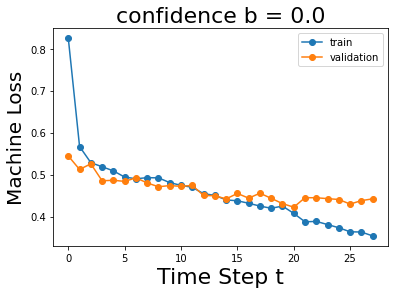

In [16]:
train_confidence(data_path,0.0)

-----training machine model using constraint: 0.2  and machine model:  confidence
----- epoch: 0 -----
machine_loss: 0.9836064603017725
val_loss: 0.5962555388609568
updated the model


----- epoch: 1 -----
machine_loss: 0.570884135754212
val_loss: 0.4765922447045644
updated the model


----- epoch: 2 -----
machine_loss: 0.47661078170589777
val_loss: 0.4892428000768026


----- epoch: 3 -----
machine_loss: 0.4895233006581016
val_loss: 0.462850151459376
updated the model


----- epoch: 4 -----
machine_loss: 0.4632870218028193
val_loss: 0.4394964853922526
updated the model


----- epoch: 5 -----
machine_loss: 0.43908953601899353
val_loss: 0.4348353683948517
updated the model


----- epoch: 6 -----
machine_loss: 0.44567424512427783
val_loss: 0.4156229635079702
updated the model


----- epoch: 7 -----
machine_loss: 0.4292816908463188
val_loss: 0.4365445335706075


----- epoch: 8 -----
machine_loss: 0.4546473317820093
val_loss: 0.43886446158091225


----- epoch: 9 -----
machine_loss: 0.444179

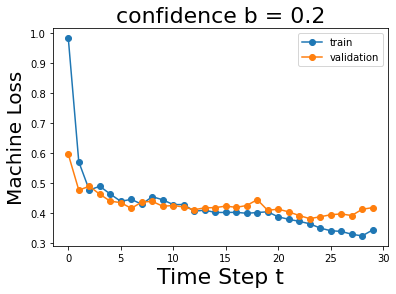

In [21]:
train_confidence(data_path,0.2)

-----training machine model using constraint: 0.4  and machine model:  confidence
----- epoch: 0 -----
machine_loss: 0.9410773625840312
val_loss: 0.5273840268452962
updated the model


----- epoch: 1 -----
machine_loss: 0.5358769200418306
val_loss: 0.4868379314740499
updated the model


----- epoch: 2 -----
machine_loss: 0.5088164469470149
val_loss: 0.46116778055826824
updated the model


----- epoch: 3 -----
machine_loss: 0.5025810268910035
val_loss: 0.47829918265342714


----- epoch: 4 -----
machine_loss: 0.4909385377946107
val_loss: 0.47370463609695435


----- epoch: 5 -----
machine_loss: 0.48571073166702106
val_loss: 0.4611693203449249


----- epoch: 6 -----
machine_loss: 0.4731283997711928
val_loss: 0.4567079802354177
updated the model


----- epoch: 7 -----
machine_loss: 0.4731310826280843
val_loss: 0.4417016804218292
updated the model


----- epoch: 8 -----
machine_loss: 0.44972535708676215
val_loss: 0.43906278610229493
updated the model


----- epoch: 9 -----
machine_loss: 0.43

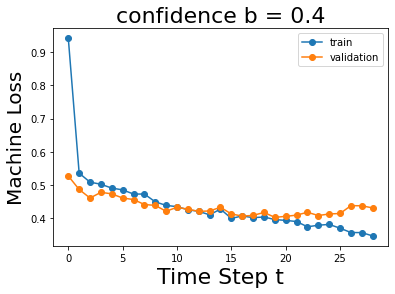

In [33]:
train_confidence(data_path,0.4)

-----training machine model using constraint: 0.6  and machine model:  confidence
----- epoch: 0 -----
machine_loss: 1.2732955437639486
val_loss: 0.686636483669281
updated the model


----- epoch: 1 -----
machine_loss: 0.6272418220405993
val_loss: 0.5543152213096618
updated the model


----- epoch: 2 -----
machine_loss: 0.52697788697222
val_loss: 0.47411112586657206
updated the model


----- epoch: 3 -----
machine_loss: 0.5001725301794384
val_loss: 0.4713470200697581
updated the model


----- epoch: 4 -----
machine_loss: 0.48503575571205304
val_loss: 0.45451491077740985
updated the model


----- epoch: 5 -----
machine_loss: 0.4756143067194068
val_loss: 0.44975496927897135
updated the model


----- epoch: 6 -----
machine_loss: 0.4580069307399833
val_loss: 0.42702869375546776
updated the model


----- epoch: 7 -----
machine_loss: 0.4561994153520335
val_loss: 0.4456571837266286


----- epoch: 8 -----
machine_loss: 0.4438396679318469
val_loss: 0.4441016753514608


----- epoch: 9 -----
mach

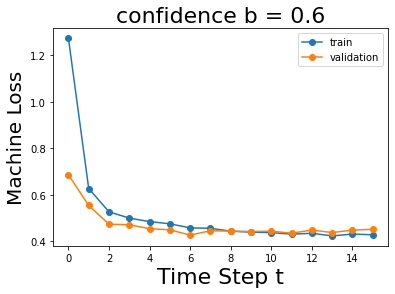

In [34]:
train_confidence(data_path,0.6)

-----training machine model using constraint: 0.8  and machine model:  confidence
----- epoch: 0 -----
machine_loss: 1.254654920619467
val_loss: 0.7215744972229003
updated the model


----- epoch: 1 -----
machine_loss: 0.7057098914747653
val_loss: 0.6900451342264812
updated the model


----- epoch: 2 -----
machine_loss: 0.6084062852289366
val_loss: 0.5391037583351135
updated the model


----- epoch: 3 -----
machine_loss: 0.5370017549265986
val_loss: 0.4858089089393616
updated the model


----- epoch: 4 -----
machine_loss: 0.5059457784113677
val_loss: 0.4810463408629099
updated the model


----- epoch: 5 -----
machine_loss: 0.4832636202159135
val_loss: 0.4735835154851278
updated the model


----- epoch: 6 -----
machine_loss: 0.4965301117171412
val_loss: 0.4720670243104299
updated the model


----- epoch: 7 -----
machine_loss: 0.4727284629707751
val_loss: 0.4583693087100983
updated the model


----- epoch: 8 -----
machine_loss: 0.46593408156996186
val_loss: 0.45436840454737343
updated th

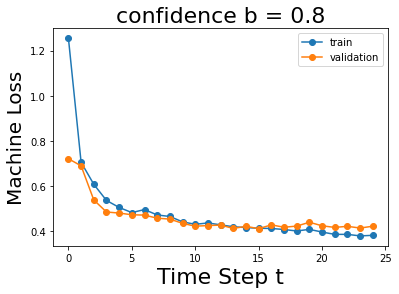

In [35]:
train_confidence(data_path,0.8)

-----training machine model using constraint: 1.0  and machine model:  confidence
----- epoch: 0 -----
machine_loss: 0.9136814118727393
val_loss: 0.5084334929784139
updated the model


----- epoch: 1 -----
machine_loss: 0.5293634417264358
val_loss: 0.5631900032361349


----- epoch: 2 -----
machine_loss: 0.5166941660901775
val_loss: 0.5007148742675781
updated the model


----- epoch: 3 -----
machine_loss: 0.5280920889066614
val_loss: 0.4863235592842102
updated the model


----- epoch: 4 -----
machine_loss: 0.4966466329667879
val_loss: 0.46532963514328
updated the model


----- epoch: 5 -----
machine_loss: 0.4945803219857423
val_loss: 0.4689193030198415


----- epoch: 6 -----
machine_loss: 0.4640257170666819
val_loss: 0.4572500209013621
updated the model


----- epoch: 7 -----
machine_loss: 0.4740153369696244
val_loss: 0.47853310108184816


----- epoch: 8 -----
machine_loss: 0.46392439759295917
val_loss: 0.46758339007695515


----- epoch: 9 -----
machine_loss: 0.4628888964653015
val_loss

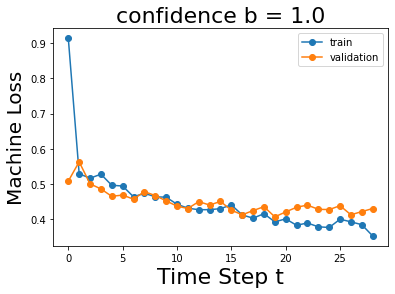

In [26]:
train_confidence(data_path,1.0)

In [17]:
def get_test_assignments_confidence(constraints):
    machine_type = 'confidence'
    res_path= res_dir + machine_type
    res = {}
    with torch.no_grad():
        loss_func = torch.nn.NLLLoss(reduction='none')
        data = load_data(data_path)
        test_X = torch.from_numpy(data['test']['X']).float().to(device)
        test_Y = torch.from_numpy(data['test']['Y']).long()
        hlabel = data['test']['hpred']
        hconf = (torch.mean(data['hconf']) + torch.zeros(test_X.shape[0])).to(device)
        hcrossloss = data['test']['hloss']

        batch_size = 128
        num_batches = int(test_X.shape[0]/batch_size)

        losses = []
        for constraint in constraints:
            res[constraint] = {}
            loss = np.zeros(test_X.shape[0])
            mnet = models.resnet50()
            mnet.fc = torch.nn.Sequential(
            nn.Linear(mnet.fc.in_features, 2),
            nn.LogSoftmax(dim = -1)
            )
            mnet.to(device)

            mnet.load_state_dict(torch.load(model_dir + 'm_' + machine_type + str(constraint)))
            mnet.eval()
            loss_batches = 0
            machine_scores = mnet(test_X)
            mcrossloss = loss_func(machine_scores,test_Y.to(device))
            mlabel = torch.argmax(machine_scores,dim=1).cpu().data.numpy()
            machine_conf, _ = torch.max(machine_scores,axis = 1)  
            num_machine = int((1.0-constraint) * test_X.shape[0])
            to_machine = find_machine_samples(hconf,machine_conf,constraint).cpu().data.numpy()

            to_human = np.array([i for i in range(test_X.shape[0]) if i not in to_machine])

            mloss = np.not_equal(mlabel,test_Y)
            hloss = np.not_equal(hlabel,test_Y)

            loss[to_machine] = mloss[to_machine]
            loss[to_human] =  hloss[to_human]
            print(to_machine.shape[0],to_human.shape[0],test_X.shape[0])
            print(np.mean(loss[to_machine]),np.mean(loss[to_human]))
            print('-----')

            losses.append(np.mean(loss))
            
            res[constraint]['mpredloss'] = mloss
            res[constraint]['mcrossloss'] = mcrossloss
            res[constraint]['mlabel'] = mlabel
            res[constraint]['mconf'] = machine_conf
            res[constraint]['mscore'] = machine_scores
            res[constraint]['hpredloss'] = hloss
            res[constraint]['hcrossloss'] = hcrossloss
            res[constraint]['hlabel'] = hlabel
            res[constraint]['to_machine'] = to_machine
            res[constraint]['to_human'] = to_human
            res[constraint]['agg_loss'] = np.mean(loss)
        
            del mnet

        plt.plot(constraints,losses,marker='o')
        plt.title(r'Confidence-based Triage',fontsize=22)
        plt.ylabel(r'misclassification error',fontsize=22)
        plt.xlabel(r'b',fontsize=22)
        plt.show()



        save_data(res,res_path)

1999 1 2000
0.192096048024012 0.0
-----
1790 210 2000
0.16201117318435754 0.3380952380952381
-----
1757 243 2000
0.17188389299943085 0.31275720164609055
-----
1727 273 2000
0.1789229878401853 0.29304029304029305
-----
1779 221 2000
0.17931422147273748 0.2895927601809955
-----
1804 196 2000
0.1729490022172949 0.30612244897959184
-----


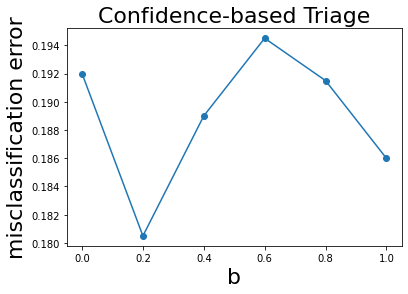

In [18]:
get_test_assignments_confidence(constraints)

## Full Automation Triage
The machine model is trained under full automation and then an additional model g is trained based on the difference of machine and human loss and used to outsource samples at test time.

In [72]:
def train_full(data_path, machine_type):
    print('-----training machine model: ',machine_type)
    data = load_data(data_path)
    X = torch.from_numpy(data['X']).float()
    Y = torch.from_numpy(data['Y']).long()
    
    val_X = torch.from_numpy(data['val']['X']).float()
    val_Y = torch.from_numpy(data['val']['Y']).long()
    
    batch_size = 128
    num_batches = int(X.shape[0] / batch_size)
    val_num_batches = int(val_X.shape[0]/batch_size)
    
    num_epochs = 30
        
    mnet = models.resnet50()
    mnet.fc = torch.nn.Sequential(
        nn.Linear(2048, 2),
        nn.LogSoftmax(dim = -1)
    )
    mnet.to(device)

    optimizer = torch.optim.Adam(mnet.parameters(),lr=0.0045)
    loss_func = torch.nn.NLLLoss(reduction='none')
    train_losses = []
    val_losses = []
    best_val_loss = 1000
    max_patience = 10
    patience = 0
    eps = 1e-4
    for epoch in range(num_epochs):
        print('----- epoch:',epoch, '-----')
        train_loss = 0
        machine_loss = []
        for i in range(num_batches):
            X_batch = X[i * batch_size: (i + 1) * batch_size].to(device)
            Y_batch = Y[i * batch_size: (i + 1) * batch_size].to(device)
            optimizer.zero_grad()
            loss = loss_func(mnet(X_batch),Y_batch)
            loss.sum().backward()
            optimizer.step()
            train_loss += float(loss.mean())

        train_losses.append(train_loss / num_batches)
        print('machine_loss:', train_loss/num_batches)
        
        
        with torch.no_grad():
            val_loss = 0
            for i in range(val_num_batches):
                val_X_batch = val_X[i * batch_size: (i + 1) * batch_size].to(device)
                val_Y_batch = val_Y[i * batch_size: (i + 1) * batch_size].to(device)
                val_loss += float(loss_func(mnet(val_X_batch),val_Y_batch).mean())

            val_loss /= val_num_batches
            print('val_loss:',val_loss) 

            if val_loss + eps < best_val_loss:
                torch.save(mnet.state_dict(), model_dir + 'm_' + machine_type)
                best_val_loss = val_loss
                print('updated the model')
                patience = 0
            else:
                patience += 1
            val_losses.append(val_loss)

        if patience > max_patience:
            print('no progress for 10 epochs... stopping training')
            break
        print('\n')
        
    del mnet
    del data
    del X
    del Y
    del val_X
    del val_Y
    
    
    plt.plot(range(len(train_losses)),train_losses,marker='o',label='train')
    plt.plot(range(len(val_losses)),val_losses,marker='o',label = 'validation')
    plt.legend()
    plt.title(machine_type, fontsize=22)
    plt.xlabel(r'Time Step t',fontsize=22)
    plt.ylabel(r'Machine Loss',fontsize=20)
    plt.show()
        

-----training machine model:  full
----- epoch: 0 -----
machine_loss: 0.7951889731313871
val_loss: 0.693795895576477
updated the model


----- epoch: 1 -----
machine_loss: 0.5758946829515955
val_loss: 0.5912232100963593
updated the model


----- epoch: 2 -----
machine_loss: 0.5525561584078748
val_loss: 0.5234678427378336
updated the model


----- epoch: 3 -----
machine_loss: 0.511331847180491
val_loss: 0.5103634277979533
updated the model


----- epoch: 4 -----
machine_loss: 0.5121530352727227
val_loss: 0.4948545634746552
updated the model


----- epoch: 5 -----
machine_loss: 0.5054926405782285
val_loss: 0.49355310599009194
updated the model


----- epoch: 6 -----
machine_loss: 0.48960870245228644
val_loss: 0.4798250178496043
updated the model


----- epoch: 7 -----
machine_loss: 0.4828985916531604
val_loss: 0.4716329455375671
updated the model


----- epoch: 8 -----
machine_loss: 0.4725311456815056
val_loss: 0.4898667355378469


----- epoch: 9 -----
machine_loss: 0.47196472857309424
v

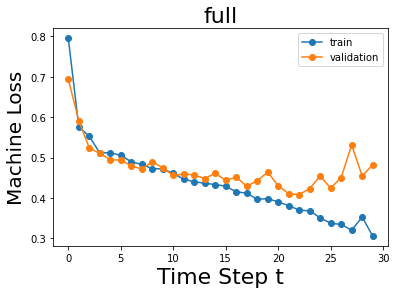

In [14]:
train_full(data_path,'full')

In [11]:
def train_g_full(data_path):
    machine_type = 'full'
    print('started training g Using machine model: ',machine_type)
    data = load_data(data_path)
    X = torch.from_numpy(data['X']).float()
    Y = torch.from_numpy(data['Y']).long()
    hloss = data['hloss']
    
    with torch.no_grad():
        mnet = models.resnet50()
        mnet.fc = torch.nn.Sequential(
        nn.Linear(2048, 2),
        nn.LogSoftmax(dim = -1)
        )

        mnet.load_state_dict(torch.load(model_dir + 'm_full'))

        mnet.to(device)
        mnet.eval()
    
    
    val_X = torch.from_numpy(data['val']['X']).float()
    val_Y = torch.from_numpy(data['val']['Y']).long()
    val_hloss = data['val']['hloss']
    
    batch_size = 128
    num_batches = int(X.shape[0] / batch_size)
    val_num_batches = int(val_X.shape[0] / batch_size)
    
    num_epochs = 30
    
    gnet = models.resnet50()
    gnet.fc = torch.nn.Sequential(
        nn.Linear(2048, 2),
        nn.LogSoftmax(dim = -1)
    )
    gnet.to(device)
    g_optimizer = torch.optim.Adam(gnet.parameters(),lr=0.005)
    loss_func = torch.nn.NLLLoss(reduction='none')
    

    train_losses = []
    val_losses = []
    best_val_loss = 1000
    max_patience = 8
    patience = 0
    eps = 1e-3
    
    for epoch in range(num_epochs):
        gprediction = []
        print('----- epoch:',epoch, '-----')
        g_train_loss = 0
        for i in range(num_batches):
            X_batch = X[i * batch_size: (i + 1) * batch_size].to(device)
            Y_batch = Y[i * batch_size: (i + 1) * batch_size].to(device)
            hloss_batch = hloss[i * batch_size: (i + 1) * batch_size].to(device)
            with torch.no_grad():
                machine_loss_batch = loss_func(mnet(X_batch),Y_batch)
                machine_indices = find_machine_samples(machine_loss_batch, hloss_batch, constraint=1.0)
            g_labels = torch.tensor([0 if j in machine_indices else 1 for j in range(hloss_batch.shape[0])]).to(device)
            g_optimizer.zero_grad()
            gpred = gnet(X_batch)
            gprediction.extend(gpred[:,1])
            g_loss = loss_func(gpred,g_labels)
            g_loss.sum().backward()
            g_optimizer.step()
            g_train_loss += float(g_loss.mean())

            
        train_losses.append(g_train_loss/num_batches)
        print('g_loss:',g_train_loss/num_batches) 
        
        with torch.no_grad():
            val_gloss = 0
            for i in range(val_num_batches):
                val_X_batch = val_X[i * batch_size: (i + 1) * batch_size].to(device)
                val_Y_batch = val_Y[i * batch_size: (i + 1) * batch_size].to(device)
                val_hloss_batch = val_hloss[i * batch_size: (i + 1) * batch_size].to(device)
                val_machine_loss = loss_func(mnet(val_X_batch),val_Y_batch)
                val_machine_indices = find_machine_samples(val_machine_loss,val_hloss_batch,constraint=1.0)
                val_glabels = torch.tensor([0 if j in val_machine_indices else 1 for j in range(val_X_batch.shape[0])]).to(device)
                val_loss = loss_func(gnet(val_X_batch),val_glabels)
                val_gloss += float(val_loss.mean())

                
            val_gloss /= val_num_batches
            val_losses.append(val_gloss)
            print('val_g_loss:',float(val_gloss))

            if val_gloss + eps < best_val_loss:
#                 torch.save(gnet.state_dict(), model_dir + 'g_' + machine_type)
                best_val_loss = val_gloss
                print('updated the model')
                patience = 0
            else:
                patience += 1

        if patience > max_patience:
            print('no progress for 10 epochs... stopping training')
            break
                
        print('\n')
        
    del gnet
    del mnet
        
    plt.plot(range(len(train_losses)),train_losses,marker = 'o',label='train')
    plt.plot(range(len(val_losses)),val_losses,marker = 'o',label='validation')
    plt.title('train and validation curve of g' ,fontsize=22)
    plt.xlabel('Epoch',fontsize=22)
    plt.ylabel(r'g Loss',fontsize=20)
    plt.legend()
    plt.show()

In [ ]:
train_g_full(data_path)

started training g Using machine model:  full
----- epoch: 0 -----
g_loss: 0.6199711104450019
val_g_loss: 0.5049737532933553
updated the model


----- epoch: 1 -----
g_loss: 0.39470849801664765
val_g_loss: 0.5166124006112417


----- epoch: 2 -----
g_loss: 0.40509797632694244
val_g_loss: 0.5205304026603699


----- epoch: 3 -----
g_loss: 0.37445189447506616
val_g_loss: 0.47352012197176613
updated the model


----- epoch: 4 -----
g_loss: 0.36775825917720795
val_g_loss: 0.4735121548175812


----- epoch: 5 -----
g_loss: 0.3674152878963429
val_g_loss: 0.4697601854801178
updated the model


----- epoch: 6 -----
g_loss: 0.36659605153228925
val_g_loss: 0.46933678587277733


----- epoch: 7 -----
g_loss: 0.36545662031225534
val_g_loss: 0.4651414056619008
updated the model


----- epoch: 8 -----
g_loss: 0.3640878874322642
val_g_loss: 0.46360615094502766
updated the model


----- epoch: 9 -----
g_loss: 0.36270037487797113
val_g_loss: 0.45972562034924824
updated the model


----- epoch: 10 -----


In [27]:
def get_test_assignments_full(constraints):
    with torch.no_grad():
        machine_type = 'full'
        threshold_map = {0.0:0.0,0.2:0.30,0.4:0.30,0.6:0.30,0.8:0.21,1.0:0.37}
        res_path = res_dir + machine_type
        res = {}
        loss_func = torch.nn.NLLLoss(reduction='none')
        data = load_data(data_path)
        test_X = torch.from_numpy(data['test']['X']).float().to(device)
        test_Y = data['test']['Y']
        hlabel = data['test']['hpred']
        hcrossloss = data['test']['hloss']

        mnet = models.resnet50()
        mnet.fc = torch.nn.Sequential(
            nn.Linear(2048, 2),
            nn.LogSoftmax(dim = -1)
        )
        mnet.to(device)
        mnet.load_state_dict(torch.load(model_dir + 'm_full'))
        mnet.eval()
        mscores = mnet(test_X)
        mcrossloss=loss_func(mscores,torch.tensor(test_Y).to(device))
        mlabel = torch.argmax(mscores,dim=1).cpu().data.numpy()

        gnet = models.resnet50()
        gnet.fc = torch.nn.Sequential(
        nn.Linear(2048, 2),
        nn.LogSoftmax(dim = -1)
        )
        gnet.to(device)
        gnet.load_state_dict(torch.load(model_dir + 'g_full'))
        gnet.eval()
        gprediction = torch.exp(gnet(test_X).detach()[:,1])
        
        
        argsorted_g = torch.argsort(gprediction)
        

        losses = []
        for constraint in constraints:
            res[constraint] = {}
            num_machine = int((1.0 - constraint) * test_X.shape[0])
            loss = np.zeros(test_X.shape[0])

            human_candidates = torch.argsort(gprediction)[num_machine:]
            to_machine = [i for i in range(mlabel.shape[0]) if i not in human_candidates or gprediction[i]<threshold_map[constraint]]
            to_human = np.array([i for i in range(test_X.shape[0]) if i not in to_machine])
            
            mloss = np.not_equal(mlabel,test_Y)
            hloss = np.not_equal(hlabel,test_Y)
            print(len(to_machine),len(to_human))
            if len(to_machine)!=0:
                loss[to_machine] = mloss[to_machine]
                print('mean of machine error:' ,np.mean(loss[to_machine]))
            if to_human.shape[0]!=0:
                loss[to_human] = hloss[to_human]
                print('mean of human error:' ,np.mean(loss[to_human]))
                

            res[constraint]['mpredloss'] = mloss
            res[constraint]['mlabel'] = mlabel
            res[constraint]['mcrossloss'] = mcrossloss
            
            res[constraint]['mscore'] = mscores
            res[constraint]['hcrossloss'] = hcrossloss
            res[constraint]['hpredloss'] = hloss
            res[constraint]['hlabel'] = hlabel
            res[constraint]['gprediction'] = gprediction
            res[constraint]['to_machine'] = to_machine
            res[constraint]['to_human'] = to_human
            res[constraint]['agg_loss'] = np.mean(loss)
            losses.append(np.mean(loss))
            print('----')


        plt.plot(constraints,losses,marker='o')
        plt.title(r'Full Automaion Triage',fontsize=22)
        plt.ylabel(r'misclassification error',fontsize=22)
        plt.xlabel(r'b',fontsize=22)
        plt.show()

        del mnet
        del gnet
        save_data(res,res_path)


2000 0
mean of machine error: 0.194
----
1994 6
mean of machine error: 0.19358074222668004
mean of human error: 0.16666666666666666
----
1994 6
mean of machine error: 0.19358074222668004
mean of human error: 0.16666666666666666
----
1994 6
mean of machine error: 0.19358074222668004
mean of human error: 0.16666666666666666
----
1956 44
mean of machine error: 0.19580777096114518
mean of human error: 0.29545454545454547
----
1996 4
mean of machine error: 0.1938877755511022
mean of human error: 0.25
----


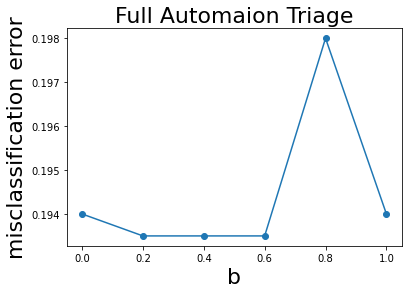

In [28]:
get_test_assignments_full(constraints)

## [Score-based Triage](https://arxiv.org/abs/1903.12220)

-----training machine model:  score
----- epoch: 0 -----
machine_loss: 0.9264855086803436
val_loss: 0.7165816883246104
updated the model


----- epoch: 1 -----
machine_loss: 0.6293092732844145
val_loss: 0.5620789329210917
updated the model


----- epoch: 2 -----
machine_loss: 0.5974931250447812
val_loss: 0.5385250528653462
updated the model


----- epoch: 3 -----
machine_loss: 0.5449007185904876
val_loss: 0.5276639044284821
updated the model


----- epoch: 4 -----
machine_loss: 0.5399725761102594
val_loss: 0.5312572161356608


----- epoch: 5 -----
machine_loss: 0.5243160893087802
val_loss: 0.5036724408467611
updated the model


----- epoch: 6 -----
machine_loss: 0.532831534743309
val_loss: 0.48833147486050926
updated the model


----- epoch: 7 -----
machine_loss: 0.5080775126166965
val_loss: 0.4807102163632711
updated the model


----- epoch: 8 -----
machine_loss: 0.490492507815361
val_loss: 0.4793009102344513
updated the model


----- epoch: 9 -----
machine_loss: 0.5038908311854238
va

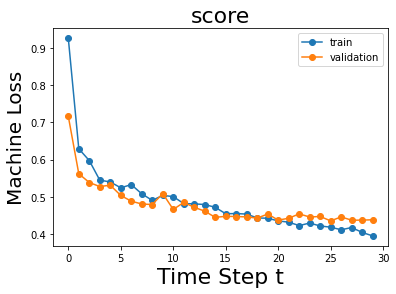

In [78]:
train_full(data_path,'score')

In [79]:
def get_assignments_score(constraints):
    with torch.no_grad():
        machine_type = 'score'
        res_path = res_dir + machine_type
        res = {}
        loss_func = torch.nn.NLLLoss(reduction='none')
        data = load_data(data_path)
        test_X = torch.from_numpy(data['test']['X']).float().to(device)
        test_Y = data['test']['Y']
        hlabel = data['test']['hpred']
        hcrossloss = data['test']['hloss']

        mnet = models.resnet50()
        mnet.fc = torch.nn.Sequential(
            nn.Linear(2048, 2),
            nn.LogSoftmax(dim = -1)
        )

        mnet.load_state_dict(torch.load(model_dir + 'm_score'))
        mnet.to(device)
        mnet.eval()
        mscores = mnet(test_X)
        mcrossloss = loss_func(mscores,torch.tensor(test_Y).to(device))
        mlabel = torch.argmax(mscores,dim=1).cpu().data.numpy()
        mconf,_ = torch.max(mnet(test_X),axis = 1)

        losses = []
        for constraint in constraints:
            res[constraint] = {}
            loss = np.zeros(test_X.shape[0])
            num_machine = int((1.0-constraint) * test_X.shape[0])
            to_machine = torch.argsort(mconf,descending = True)[:num_machine].cpu().data.numpy()
            to_human = np.array([i for i in range(test_X.shape[0]) if i not in to_machine])

            mloss = np.not_equal(mlabel,test_Y)
            hloss = np.not_equal(hlabel,test_Y)
            print(len(to_machine),len(to_human ))
            
            if len(to_machine)!=0:
                loss[to_machine] = mloss[to_machine]
                print('mean of machine error:' ,np.mean(loss[to_machine]))
            if to_human.shape[0]!=0:
                loss[to_human] = hloss[to_human]
                print('mean of human error:' ,np.mean(loss[to_human]))
                

            res[constraint]['mcrossloss'] = mcrossloss
            res[constraint]['mpredloss'] = mloss
            res[constraint]['mlabel'] = mlabel
            res[constraint]['mconf'] = mconf
            res[constraint]['hcrossloss'] = hcrossloss
            res[constraint]['hpredloss'] = hloss
            res[constraint]['hlabel'] = hlabel
            res[constraint]['to_machine'] = to_machine
            res[constraint]['to_human'] = to_human
            res[constraint]['agg_loss'] = np.mean(loss)
            losses.append(np.mean(loss))
            print('----')

        plt.plot(constraints,losses,marker='o')
        plt.title(r'Score-based Triage',fontsize=22)
        plt.ylabel(r'misclassification error',fontsize=22)
        plt.xlabel(r'b',fontsize=22)
        plt.show()

        del mnet
        save_data(res,res_path)


2000 0
mean of machine error: 0.1955
----
1600 400
mean of machine error: 0.153125
mean of human error: 0.27
----
1200 800
mean of machine error: 0.105
mean of human error: 0.2625
----
800 1200
mean of machine error: 0.07
mean of human error: 0.25583333333333336
----
399 1601
mean of machine error: 0.09273182957393483
mean of human error: 0.23360399750156152
----
0 2000
mean of human error: 0.233
----


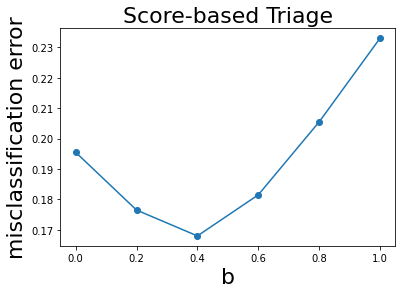

In [80]:
get_assignments_score(constraints)

## [Surrogate-based Triage](https://arxiv.org/abs/2006.01862)
The code is taken from [here](https://github.com/clinicalml/learn-to-defer) where the authors provide implementation of their method.

In [6]:
def surrogate_train(data_path):

    def loss_func(outputs, m, labels, m2, n_classes):
        '''
        The L_{CE} loss implementation for hatespeech, identical to CIFAR implementation
        ----
        outputs: network outputs
        m: cost of deferring to expert cost of classifier predicting (alpha* I_{m\neq y} + I_{m =y})
        labels: target
        m2:  cost of classifier predicting (alpha* I_{m\neq y} + I_{m =y})
        n_classes: number of classes
        '''
        batch_size = outputs.shape[0]
        rc = [n_classes] * batch_size

        rc = torch.tensor(rc)

        outputs = -m * torch.log2(outputs[range(batch_size), rc]) - m2 * torch.log2(outputs[range(batch_size), labels])  # pick the values corresponding to the labels
        return torch.sum(outputs)/batch_size
    
    print('-----training machine model : surrogate')
    machine_type = 'surrogate'
    data = load_data(data_path)
    X = torch.from_numpy(data['X']).float().to(device)
    Y = torch.from_numpy(data['Y']).to(device).long()
    human_is_correct = torch.from_numpy(np.array([1 if data['hpred'][i]==data['Y'][i] else 0
                                                  for i in range(X.shape[0])])).to(device)
    alpha = 1.0
    m = (1 - human_is_correct) * 1.0
    m2 = [1.0] * X.shape[0]
    m2 = torch.tensor(m2)
    for j in range(0, X.shape[0]):
        exp = m[j].item()
        if exp:
            m2[j] = alpha
        else:
            m2[j] = 1
    m2 = m2.to(device)


    val_X = torch.from_numpy(data['val']['X']).float().to(device)
    val_Y = torch.from_numpy(data['val']['Y']).to(device).long()
    val_human_is_correct = torch.from_numpy(np.array([1 if data['val']['hpred'][i] == data['val']['Y'][i] else 0
                                                      for i in range(val_X.shape[0])])).to(device)
    val_m = (1 - val_human_is_correct) * 1.0
    val_m2 = [1.0] * val_X.shape[0]
    val_m2 = torch.tensor(val_m2)
    for j in range(0, val_X.shape[0]):
        exp = val_m[j].item()
        if exp:
            val_m2[j] = alpha
        else:
            val_m2[j] = 1
    val_m2 = val_m2.to(device)
    
    batch_size = 64
    num_epochs = 30

    num_batches = int(X.shape[0] / batch_size)
    
    
    output_dim = 2
    mnet = models.resnet50()
    mnet.fc = torch.nn.Sequential(
        nn.Linear(2048, output_dim + 1),
        nn.Softmax(dim = -1)
    )
    mnet.to(device)

    optimizer = torch.optim.Adam(mnet.parameters(),lr=0.0025)
    train_losses = []
    val_losses = []
    best_val_loss = 1000
    max_patience = 8
    patience = 0
    eps = 1e-4

    for epoch in range(num_epochs):
        print('----- epoch:',epoch, '-----')
        epoch_loss = 0
        val_epoch_loss = 0
        for i in range(num_batches):
            X_batch = X[i * batch_size:(i + 1) * batch_size]
            Y_batch = Y[i * batch_size:(i + 1) * batch_size]
            m_batch = m[i * batch_size:(i + 1) * batch_size]
            m2_batch = m2[i * batch_size:(i + 1) * batch_size]

            optimizer.zero_grad()
            loss = loss_func(mnet(X_batch),m_batch,Y_batch,m2_batch,output_dim)
            loss.backward()
            optimizer.step()
            epoch_loss += float(loss)


        print('train loss: ',epoch_loss/ num_batches)
        train_losses.append(epoch_loss / num_batches)
        with torch.no_grad():
            m_val_prob = mnet(val_X)
            val_loss = loss_func(m_val_prob, val_m, val_Y, val_m2, output_dim)
            val_losses.append(float(val_loss))
            print('validation loss: ', float(val_loss))
            
            if val_loss < best_val_loss:
                torch.save(mnet.state_dict(), model_dir + 'm_surrogate')
                best_val_loss = val_loss
                print('updated the model')
                patience = 0
            else:
                patience += 1
            
            if patience > max_patience:
                print('no progress for 10 epochs... stopping training')
                break
    
        print('\n')
            
    plt.plot(range(len(train_losses)),train_losses,marker='o',label = 'train')
    plt.plot(range(len(val_losses)),val_losses,marker='o', label = 'validation')
    plt.legend()
    plt.title(machine_type,fontsize=22)
    plt.xlabel(r'Time Step t',fontsize=22)
    plt.ylabel(r'Machine Loss',fontsize=20)
    plt.legend()
    plt.show()

-----training machine model : surrogate
----- epoch: 0 -----
train loss:  2.0029437964962375
validation loss:  1.6301988363265991
updated the model


----- epoch: 1 -----
train loss:  1.6541229486465454
validation loss:  1.52461576461792
updated the model


----- epoch: 2 -----
train loss:  1.6185505672167706
validation loss:  1.5127768516540527
updated the model


----- epoch: 3 -----
train loss:  1.6026107944468015
validation loss:  1.497266173362732
updated the model


----- epoch: 4 -----
train loss:  1.5944153160177252
validation loss:  1.516893982887268


----- epoch: 5 -----
train loss:  1.5801505350297498
validation loss:  1.5078790187835693


----- epoch: 6 -----
train loss:  1.5729038567953213
validation loss:  1.5145570039749146


----- epoch: 7 -----
train loss:  1.5830822349876486
validation loss:  1.5006612539291382


----- epoch: 8 -----
train loss:  1.5645961018018826
validation loss:  1.5054079294204712


----- epoch: 9 -----
train loss:  1.5550773566769016
validation 

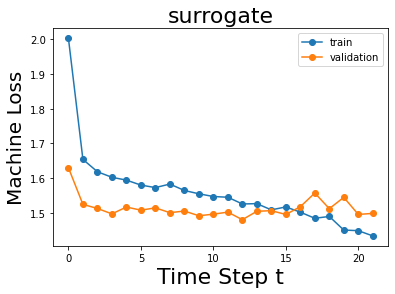

In [7]:
surrogate_train(data_path)

In [10]:
def get_test_assignments_surrogate(constraints):
    loss_func = torch.nn.NLLLoss(reduction='none')
    with torch.no_grad():
        machine_type = 'surrogate'
        res_path = res_dir + machine_type
        res = {}
        
        data = load_data(data_path)
        test_X = torch.from_numpy(data['test']['X']).float().to(device)
        test_Y = data['test']['Y']
        hlabel = data['test']['hpred']
        hcrossloss = data['test']['hloss']

        mnet = models.resnet50()
        mnet.fc = torch.nn.Sequential(
            nn.Linear(2048, 2 + 1),
            nn.Softmax(dim = -1)
        )
        mnet.to(device)

        mnet.load_state_dict(torch.load(model_dir + 'm_surrogate'))
        mnet.eval()
        mscores = mnet(test_X)
        print(mscores[:,:-1])
        mcrossloss = loss_func(mscores,torch.tensor(test_Y).to(device))
        print(mcrossloss)
        assert(mscores.shape[1]==3)
        mlabel = torch.argmax(mscores[:,:-1],dim=1).cpu().data.numpy()
        assert (mlabel<3).all()
        
        last_class_prob = mscores[:,-1]
        highest_prob,_ = torch.max(mscores[:,:-1],dim=1)
        diff = last_class_prob - highest_prob
        print(diff)

        losses = []
        for constraint in constraints:
            res[constraint] = {}
            loss = np.zeros(test_X.shape[0])
            num_machine = int((1.0-constraint) * test_X.shape[0])
            human_candidates = torch.argsort(diff)[num_machine:].cpu().data.numpy()
            
            to_machine = [i for i in range(mlabel.shape[0]) if i not in human_candidates]
            
            to_human = np.array([i for i in range(mlabel.shape[0]) if i not in to_machine])

            mloss = np.not_equal(mlabel,test_Y)
            hloss = np.not_equal(hlabel,test_Y)

            if len(to_machine)!=0:
                loss[to_machine] = mloss[to_machine]
                print('mean of machine error:' ,np.mean(loss[to_machine]))
            if to_human.shape[0]!=0:
                loss[to_human] = hloss[to_human]
                print('mean of human error:' ,np.mean(loss[to_human]))
                
            losses.append(np.mean(loss))

            res[constraint]['mcrossloss'] = mcrossloss
            res[constraint]['mclassloss'] = mloss
            res[constraint]['mlabel'] = mlabel
            res[constraint]['mscore'] = mscores
            res[constraint]['hpredloss'] = hloss
            res[constraint]['hcrossloss'] = hcrossloss
            res[constraint]['hlabel'] = hlabel
            res[constraint]['to_machine'] = to_machine
            res[constraint]['to_human'] = to_human
            res[constraint]['agg_loss'] = np.mean(loss)

        plt.plot(constraints,losses,marker='o')
        plt.title(r'Surrogate-based Triage',fontsize=22)
        plt.ylabel(r'misclassification error',fontsize=22)
        plt.xlabel(r'b',fontsize=22)
        del mnet
#         save_data(res,res_path)


tensor([[0.1147, 0.6949],
        [0.3396, 0.4297],
        [0.8835, 0.0161],
        ...,
        [0.1130, 0.6996],
        [0.6842, 0.1089],
        [0.1124, 0.7006]], device='cuda:0')
tensor([-0.6949, -0.4297, -0.8835,  ..., -0.1130, -0.6842, -0.7006],
       device='cuda:0')
tensor([-0.5044, -0.1990, -0.7831,  ..., -0.5122, -0.4773, -0.5136],
       device='cuda:0')
2000 0
mean of machine error: 0.2275
1600 400
mean of machine error: 0.166875
mean of human error: 0.26
1200 800
mean of machine error: 0.1225
mean of human error: 0.25875
800 1200
mean of machine error: 0.085
mean of human error: 0.26
399 1601
mean of machine error: 0.07017543859649122
mean of human error: 0.24921923797626483
0 2000
mean of human error: 0.233


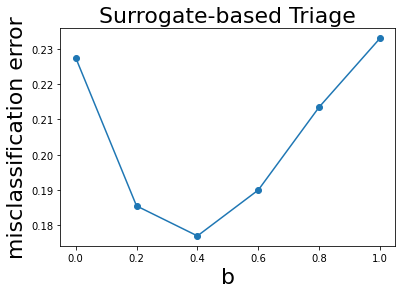

In [11]:
get_test_assignments_surrogate(constraints)

In [17]:
def plot_misclassification_loss(machine_types):
    res_dir = 'results/'
    for machine_type in machine_types:
        agg_loss = []
        res = load_data(res_dir + machine_type)
        agg_loss = [res[constraint]['agg_loss'] for constraint in constraints]
        plt.plot(constraints,agg_loss,marker='o',label=machine_type)
    plt.xticks(constraints)
    plt.ylabel(r'misclassification error',fontsize=22)
    plt.xlabel(r'b',fontsize=22)
    plt.legend()

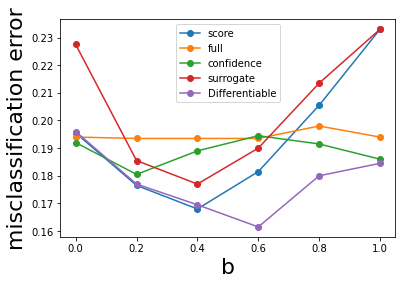

In [18]:
machine_types =  ['score','full','confidence','surrogate','Differentiable']
plot_misclassification_loss(machine_types)